# Use Case Tutorial: Retail Demand Forecasting using DataRobot Python API and Time-series Helper Functions

### In this use case, we are forecasting Candy sales for the next month from a single store. The store owner wants to decide which types and how much of each candy to stock for the next month, and potentially limit inventory to only high sales items. We have over 2 years of historical transaction data from the candy store. (Note on data: data does not actually correspond candy sales, but original sales data was anonymized and converted to candy sales to protect data source privacy)

In [1]:
# import packages
import datarobot as dr
import datarobot_ts_helpers as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import os
import re
from importlib import reload
import plotly.express as px
import plotly.graph_objects as go
import time

# set pandas configuration to show all columns
pd.set_option("display.max_columns", None)

### Connect to DataRobot Python API Client

In [2]:
# configure connection to DataRobot
# endpoint and API-token are stored in a config file
# US-server
dr.Client(
    config_path="/Users/jarred.bultema/.config/datarobot/drconfig.yaml",
    connect_timeout=50000,
)

# EU-server
# dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig_eu.yaml', connect_timeout= 50000)


---------------

# Import Dataset

In [3]:
# upload the clustered data from the previous notebook
df_w_clusters = pd.read_csv("data/data_for_modeling.csv", index_col=0)
df_w_clusters["date"] = pd.to_datetime(df_w_clusters["date"])

# "project 1" modeled all of the data in a single cluster
# we will just spoof clustering by adding a single value for all series
# this will allow us to perform analysis with the following functions
df_w_clusters["Cluster"] = 0

# upload data from clustered projects
df_w_clusters_2 = pd.read_csv("data/project_2_data.csv", index_col=0)
df_w_clusters_2["date"] = pd.to_datetime(df_w_clusters_2["date"])
df_w_clusters_3 = pd.read_csv("data/project_3_data.csv", index_col=0)
df_w_clusters_3["date"] = pd.to_datetime(df_w_clusters_3["date"])

In [4]:
df_w_clusters.head()

item_name       date  package_id_min  package_id_max  \
467                3 Musketeers 2017-02-03    1.700000e+09    1.700000e+09   
3006           Hersheys Krackel 2017-02-03    1.700000e+09    1.700000e+09   
7865         Milky Way Midnight 2017-02-03    1.700000e+09    1.700000e+09   
12542         Reeses Miniatures 2017-02-03    1.700000e+09    1.700000e+09   
13380  Reeses Peanut Butter cup 2017-02-03    1.700000e+09    1.700000e+09   

       package_id_unique     campaign_min     campaign_max  campaign_unique  \
467                  1.0  discount_type_1  discount_type_1              1.0   
3006                 1.0  discount_type_1  discount_type_1              1.0   
7865                 1.0  discount_type_1  discount_type_1              1.0   
12542                1.0  discount_type_1  discount_type_1              1.0   
13380                1.0  discount_type_1  discount_type_1              1.0   

       qty_min  qty_mean  qty_max  qty_stdev  qty_unique  qty_sum  \
467       0.56      0.56     0.56        NaN         1.0     0.56   
3006      0.56      0.56     0.56        NaN         1.0     0.56   
7865      0.56      0.56     0.56        NaN         1.0     0.56   
12542     0.56      0.56     0.56        NaN         1.0     0.56   
13380     0.56      0.56     0.56        NaN         1.0     0.56   

       unit_price_min  unit_price_mean  unit_price_max  unit_price_stdev  \
467               0.0              0.0             0.0               NaN   
3006              0.0              0.0             0.0               NaN   
7865              0.0              0.0             0.0               NaN   
12542             0.0              0.0             0.0               NaN   
13380             0.0              0.0             0.0               NaN   

       unit_price_unique  unit_price_sum  sale_amount_min  sale_amount_mean  \
467                  1.0             0.0              0.0               0.0   
3006                 1.0             0.0              0.0               0.0   
7865                 1.0             0.0              0.0               0.0   
12542                1.0             0.0              0.0               0.0   
13380                1.0             0.0              0.0               0.0   

       sale_amount_max  sale_amount_stdev  sale_amount_unique  \
467                0.0                NaN                 1.0   
3006               0.0                NaN                 1.0   
7865               0.0                NaN                 1.0   
12542              0.0                NaN                 1.0   
13380              0.0                NaN                 1.0   

       sale_amount_sum  day store_category category transaction  \
467                0.0  Fri         Type_B   Retail    Canceled   
3006               0.0  Fri         Type_B   Retail    Canceled   
7865               0.0  Fri         Type_B   Retail    Canceled   
12542              0.0  Fri         Type_B   Retail    Canceled   
13380              0.0  Fri         Type_B   Retail    Canceled   

       aggregated_total_count  metro_area  county_1  total_market_sales  \
467                       1.0         NaN       NaN                 NaN   
3006                      1.0         NaN       NaN                 NaN   
7865                      1.0         NaN       NaN                 NaN   
12542                     1.0         NaN       NaN                 NaN   
13380                     1.0         NaN       NaN                 NaN   

       Cluster  
467          0  
3006         0  
7865         0  
12542        0  
13380        0


----------------

# Project Settings

### Configure the settings to be used in the Time Series problem in DataRobot

In [5]:
# Set default values
target = "sale_amount_sum"
date_col = "date"
series_id = "item_name"
kia = None  # No columns known in advance for this dataset!
num_backtests = 3
validation_duration = 30  # want to predict 1-monath sales
holdout_duration = 30
disable_holdout = False
metric = "RMSE"  # what makes most sense in this case?
use_time_series = True
fd_start = 1
fd_end = 31  # forecasting sales for the next month
fdw_start = -28  # we should iterate on this
fdw_end = 0
max_date = df_w_clusters["date"].max()

# create Time Series settings
ts_settings = {
    "max_date": max_date,
    "known_in_advance": kia,
    "num_backtests": num_backtests,
    "validation_duration": validation_duration,
    "holdout_duration": holdout_duration,
    "disable_holdout": disable_holdout,
    "use_time_series": use_time_series,
    "series_id": series_id,
    "metric": metric,
    "target": target,
    "date_col": date_col,
    "fd_start": fd_start,
    "fd_end": fd_end,
    "fdw_start": fdw_start,
    "fdw_end": fdw_end,
}

## Lets briefly visualize the clustered data

In [6]:
# reshape the dataframe for dimensionality reduction
clusters_scaled = ts.reshape_df(df_w_clusters, ts_settings, scale=True)

#### 'reshape_df()' function docs &darr;

In [7]:
# reshape_df()

# """
# Restructures a dataset for use in dimensionality reduction

# df: Pandas DataFrame
#     Input dataframe with time series data
# ts_settings: dict
#     Pre-defined time series projet settings
# agg_level: str
#     Resampling frequency, allowed values found in pandas docs: https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.resample.html
# scale: bool
#     True / False. Controls if output df is MinMax scaled
# Returns:
# --------
# Pandas DataFrame
# """

#### 'plot_UMAP()' function docs &darr;

In [8]:
# plot_UMAP()

# """
# Perform dimensionality reduction and plot a transformed dataframe to assess clustering efficacy

# df_T: Pandas DataFrame
#     Transposed dataframe for dimensionality reduction
# df_clustered: Pandas DataFrame
#     Dataframe with series_id and cluster labels
# ts_settings: dict
#     Pre-defined time series projet settings

# Returns:
# --------
# Plotly 3D scatter plot
# """

In [7]:
# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_scaled, df_w_clusters, ts_settings)

In [8]:
# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_scaled, df_w_clusters_2, ts_settings)

In [9]:
# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_scaled, df_w_clusters_3, ts_settings)

-----------------
# Retrieve Results from DataRobot Models

### Group the DataRobot projects of interest based in the prefix used when creating the projects

In [ ]:
# if this has already been run, no need to re-run
# just retrieve the project names
project_key = "Demand_forecasting_tutorial_project_1"
project2_key = "Demand_forecasting_tutorial_project_2"
project3_key = "Demand_forecasting_tutorial_project_3"

# any incomplete projects in the project-list will cause the following functions to error
# remove those failed projects
project2_failed = []
project3_failed = []

# select only the desired DR-projects for each of the modeling runs performed on different types of clustered data
projects = [x for x in dr.Project.list() if project_key in str(x)]
projects2 = [
    x
    for x in dr.Project.list()
    if project2_key in str(x)
    if not any(z in str(x) for z in project2_failed)
]
projects3 = [
    x
    for x in dr.Project.list()
    if project3_key in str(x)
    if not any(z in str(x) for z in project3_failed)
]

### Models have been built, now we need to compute the backtest scores for all backtests on all projects

In [ ]:
%%time
# Get the results from completed projects
# Project 1
project_scores = ts.get_or_request_backtest_scores(
    projects,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)

# Project 2
project2_scores = ts.get_or_request_backtest_scores(
    projects2,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)

# Project 3
project3_scores = ts.get_or_request_backtest_scores(
    projects3,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)

#### 'get_or_request_backtest_scores()' function docs &darr;

In [21]:
# get_or_request_backtest_scores()

# """
# Get or request backtest and holdout scores from top models across multiple DataRobot projects

# projects: list
#     DataRobot project object(s)
# n_models: int
#     Number of top models to return
# data_subset: str (optional)
#     Can be set to either allBacktests or holdout
# include_blenders: boolean (optional)
#     Controls whether to include ensemble models
# metric: str (optional)
#     Project metric used to sort the DataRobot leaderboard
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'

# Returns:
# --------
# pandas df
# """

### A note on using blenders:
Including blenders in the 'best' models will limit the ability to iteratively retain models, and blenders as a whole cannot be retrained. If retraining of models (for example with reduced feature lists) is anticipated, then blenders should be exclude from the get_or_request_backtest_scores() function call.

In [22]:
%%time
# this cell can only be executed after projects has completed
# any incomplete projects in the project-list will cause this function to error
ts.compute_backtests(
    projects,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=True,
    metric="RMSE",
)

All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-56_all_series
Computing backtests for model 5f6d05dab318074df2f3ada6 in Project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-28_all_series
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-28_all_series
CPU times: user 154 ms, sys: 34.2 ms, total: 188 ms
Wall time: 12 s


#### 'compute_backtests()' function docs &darr;

In [23]:
# compute_backtests()

# """
# Compute all backtests for top models across multiple DataRobot projects

# projects: list
#     DataRobot project object(s)
# n_models: int
#     Number of top models to return
# data_subset: str (optional)
#     Can be set to either allBacktests or holdout
# include_blenders: boolean (optional)
#     Controls whether to include ensemble models
# metric: str (optional)
#     Project metric used to sort the DataRobot leaderboard
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'

# """

In [24]:
%%time
# run this to compute backtest for the other projects
# it will take several minutes to complete for these 96 total DR projects
ts.compute_backtests(
    projects2,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=True,
    metric="RMSE",
)
ts.compute_backtests(
    projects3,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=True,
    metric="RMSE",
)

All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-84_Cluster-1
Computing backtests for model 5f6d27dd481ee37cf0fff905 in Project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-84_Cluster-1
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-84_Cluster-1
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-56_Cluster-1
Computing backtests for model 5f6d249705c7c90e9fda2476 in Project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-56_Cluster-1
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-56_Cluster-1
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-28_Cluster-1
Computing backtests for model 5f6d21ba05c7c90a11da2457 in Project Demand_fore

### We can also look at the best scoring model for each project

#### For either the simple or complex (with a large number of projects) use, retrieving the best scores for a FDW is simple.

In [ ]:
%%time
# project 1
project_scores = ts.get_or_request_backtest_scores(
    projects,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)

scores_best = ts.filter_best_fdw_scores(project_scores, col_error="All_Backtests_RMSE")

In [ ]:
%%time
# project 2
project2_scores = ts.get_or_request_backtest_scores(
    projects2,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)

scores2_best = ts.filter_best_fdw_scores(
    project2_scores, col_error="All_Backtests_RMSE"
)

# project 3
project3_scores = ts.get_or_request_backtest_scores(
    projects3,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)

scores3_best = ts.filter_best_fdw_scores(
    project3_scores, col_error="All_Backtests_RMSE"
)

In [ ]:
# 'filter_best_fdw_scores()' function docs
help(ts.filter_best_fdw_scores)

In [27]:
# filter_best_fdw_scores()

# """
# Subset df to projects with the best error metric for each FD and Cluster pair

# scores: pandas df
#     Output from get_or_request_backtest_scores()
# col_error: str
#     Column name from scores df

# Returns:
# --------
# pandas df

# """

### We may be more interested in understand which project gives the best results, this is especially relevant when a larger project has been broken into many smaller constituent projects

In [ ]:
%%time
projects_best = ts.filter_best_fdw_projects(
    project_scores, projects, col_error="All_Backtests_RMSE"
)
projects2_best = ts.filter_best_fdw_projects(
    project2_scores, projects2, col_error="All_Backtests_RMSE"
)
projects3_best = ts.filter_best_fdw_projects(
    project3_scores, projects3, col_error="All_Backtests_RMSE"
)

#### 'filter_best_fdw_projects()' function docs &darr;

In [29]:
# filter_best_fdw_projects()

# """
# Subset list to projects with the best error metric for each FD and Cluster pair

# scores: pandas df
#     Output from get_or_request_backtest_scores()
# projects: list
#     DataRobot projects object(s)
# col_error: str
#     Column name from scores df

# Returns:
# --------
# list

# """

### We can evaluate performance on each cluster

In [ ]:
%%time
cluster_acc = ts.get_cluster_acc(
    df_w_clusters,
    projects_best,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)
ts.plot_cluster_acc(
    cluster_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse
)

#### 'get_cluster_acc()' and 'plot_cluster_acc()' function docs &darr;

In [31]:
# get_cluster_acc()

# """
# Get cluster-level and overall accuracy across multiple DataRobot projects

# df: pandas df
# projects: list
#     DataRobot project object(s)
# ts_settings: dict
#     Parameters for time series project
# data_subset: str
#     Valid values are either holdout or allBacktests
# include_backtests: boolean (optional)
#     Controls whether blender models are considered
# metric: str (optional)
#     Project metric used to sort the DataRobot leaderboard
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
# acc_calc: function
#     Function to calculate row-level prediction accuracy. Choose from mae, rmse, mape, smape, gamma, poission, and tweedie

# Returns:
# --------
# pandas df

# """


# plot_cluster_acc()

# """
# Plots cluster-level and overall accuracy across multiple DataRobot projects

# cluster_acc: pandas df
#     Output from get_cluster_acc()
# ts_settings: dict
#     Pparameters for time series project
# data_subset: str
#     Choose either holdout or allBacktests
# metric: str (optional)
#     Project metric used to sort the DataRobot leaderboard
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'

# Returns:
# --------
# Plotly barplot
# """

### This provides a baseline for comparison as we look at more complex modeling options.

### This plotting is more relevant for more complex use where clusters were modeled in separate projects:

In [ ]:
%%time
cluster2_acc = ts.get_cluster_acc(
    df_w_clusters_2,
    projects2_best,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)
ts.plot_cluster_acc(
    cluster2_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse
)

In [ ]:
%%time
cluster3_acc = ts.get_cluster_acc(
    df_w_clusters_3,
    projects3_best,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)
ts.plot_cluster_acc(
    cluster3_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse
)

#### At a glance, we see the overall performance of these clustered datasets broken into more DataRobot projects has improved overall accuracy non-uniformly across clusters, with little change to overall accuracy thus far. Projects 2 (with 3 clusters) shows relatively little improvement, but Project 3 (5 clusters) shows clusters with better, worse, and equivalent performance to the non-clustered, single DR project (Project 1).

#### These weaker performing clusters provide a starting point to iterate on the weakest groups. Lets see if we can identify reasons that performance is weaker across some clusters and find ways to improve overall error.

## Which series are contributing to these high error rates?

In [ ]:
%%time
series_acc = ts.get_series_acc(
    df_w_clusters,
    projects_best,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)
ts.plot_series_acc(
    series_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse, n=50
)

#### 'get_series_acc()' and 'plot_series_acc()' function docs &darr;

In [35]:
# get_series_acc()

# """
# Get series-level and overall accuracy across multiple DataRobot projects

# df: pandas df
# projects: list
#     DataRobot project object(s)
# ts_settings: dict
#     Parameters for time series project
# data_subset: str
#     Valid values are either holdout or allBacktests
# include_backtests: boolean (optional)
#     Controls whether blender models are considered
# metric: str (optional)
#     Project metric used to sort the DataRobot leaderboard
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
# acc_calc: function
#     Function to calculate row-level prediction accuracy. Choose from mae, rmse, mape, smape, gamma, poission, and tweedie

# Returns:
# --------
# pandas df

# """


# plot_series_acc()

# """
# Plots series-level and overall accuracy across multiple DataRobot projects

# cluster_acc: pandas df
#     Output from get_series_acc()
# ts_settings: dict
#     Parameters for time series project
# data_subset: str
#     Choose from either holdout or allBacktests
# metric: str (optional)
#     Project metric used to sort the DataRobot leaderboard
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'

# Returns:
# --------
# Plotly barplot
# """

In [ ]:
%%time
series2_acc = ts.get_series_acc(
    df_w_clusters_2,
    projects2_best,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)
ts.plot_series_acc(
    series2_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse, n=50
)

In [ ]:
%%time
series3_acc = ts.get_series_acc(
    df_w_clusters_3,
    projects3_best,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)
ts.plot_series_acc(
    series3_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse, n=50
)

-----------
# Evaluate Backtests

#### At this point, we notice a few things.
#### - Accuracy varies widely by series overall, and for the more complicated projects with many clusters, we see substantial variation within  those clusters.
#### - The overall accuracy is similar regardless of the number of clusters used. This might suggest that clustering isn't need for this dataset, but lets explore this a bit further to see if we can improve performance.

### How many series were included in the training data?

In [ ]:
# checking displayed series
print("Number of series in the dataset: ", df_w_clusters["item_name"].unique().shape[0])
print(
    "Projects 1: No clustering, 1 DR Project. Number of series shown on series accuracy plot: ",
    series_acc.shape[0],
)
print(
    "Projects 2: Five Clusters, 48 DR project. Number of series shown on series accuracy plot: ",
    series2_acc.shape[0],
)
print(
    "Projects 3: Eight Clusters, 48 DR project. Number of series shown on series accuracy plot: ",
    series3_acc.shape[0],
)

### There are series missing from these plots. Why?


In [ ]:
%%time
# calculate how many records are present for all series in backtests
projects_backtesting_info = ts.get_training_and_backtest_windows(
    projects_best, ts_settings, data_subset="allBacktests", metric=None
)
projects_backtests = ts.check_all_series_backtests(
    df_w_clusters, ts_settings, projects_backtesting_info
)
ts.plot_series_backtest_coverage(projects_backtests, ts_settings, n=50)

#### 'get_training_and_backtest_windows()', 'check_all_series_backtests()', and 'plot_series_backtest_coverage()' function docs &darr;

In [45]:
# get_training_and_backtest_windows()

# """
# Get training and backtest durations from models across multiple DataRobot projects

# projects: list
#     DataRobot project object(s)
# ts_settings: dict
#     Parameters for time series project
# data_subset: str (optional)
#     Can be set to either allBacktests, backtest_n (n= Backtest number), holdout
# metric: str (optional)
#     Project metric used to sort the DataRobot leaderboard
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'

# Returns:
# --------
# pandas df
# """


# check_all_series_backtests()

# """
# Plots series-level coverage across multiple backtests

# cluster_information: pandas df
#     Information about each series including a cluster id, output from add_cluster_labels()
# ts_settings: dict
#     Parameters for time series project
# backtest_information: pandas df
#     contains information on how many records are present for each series in each backtest
#     , output from get_training_and_backtest_windows()

# Returns:
# --------
# Pandas DataFrame
# """


# plot_series_backtest_coverage()

# """
# Plots series-level coverage across multiple backtests

# series_backtests: pandas df
#     Output from check_all_series_backtests()
# ts_settings: dict
#     Parameters for time series project
# data_subset: str
#     Choose from either holdout or allBacktests
# n: int
#     Number of series to display

# Returns:
# --------
# Plotly barplot
# """

In [ ]:
%%time
# calculate how many records are present for all series in backtests
projects2_backtesting_info = ts.get_training_and_backtest_windows(
    projects2_best, ts_settings, data_subset="allBacktests", metric=None
)
projects2_backtests = ts.check_all_series_backtests(
    df_w_clusters_2, ts_settings, projects2_backtesting_info
)
ts.plot_series_backtest_coverage(projects2_backtests, ts_settings, n=50)

In [ ]:
%%time
# calculate how many records are present for all series in backtests
projects3_backtesting_info = ts.get_training_and_backtest_windows(
    projects3_best, ts_settings, data_subset="allBacktests", metric=None
)
projects3_backtests = ts.check_all_series_backtests(
    df_w_clusters_3, ts_settings, projects3_backtesting_info
)
ts.plot_series_backtest_coverage(projects3_backtests, ts_settings, n=50)

#### An interesting results in this case is that series that do not have sales history over the validation windows are not present in this analysis.

#### We also notice that presence in backtests is not consistent across the different projects. This is because backtests dates were not set explicitly and there are many short series that aren't present in any of the backtests.

## Plot these series and see if it provides insight

In [ ]:
%%time
# get the series present and absent from the backtests
present_series = ts.get_series_in_backtests(
    projects3_backtests, data_subset="allBacktests", present=True, threshold=1.0
)
absent_series = ts.get_series_in_backtests(
    projects3_backtests, data_subset="allBacktests", present=False, threshold=0.25
)
print(f"Number series present: ", len(present_series))
print(f"Number series absent: ", len(absent_series))


# subset the dataframes based on series presence in backtests
df_present = df_w_clusters_3[df_w_clusters_3["item_name"].isin(present_series)].copy()
df_absent = df_w_clusters_3[df_w_clusters_3["item_name"].isin(absent_series)].copy()

#### 'get_series_in_backtests()' function docs &darr;

In [ ]:
#  get_series_in_backtests()


# """
# Selects the subset of series that are present or absent in any defined backtest
# df: Pandas df
#     Output of check_all_series_backtests(), contains information on presence of series in each backtest period
# data_subset: str
#     Which data_subsets should be included in analysis, accpets individual backtests ('backtest_1', 'allBacktests', 'holdout')
# present: bool
#     Select series that are present (True) or absent (False) from backtesting window(s)
# threshold: np.float (0.0 - 1.0)
#     cutoff threshold to determine presence

# Returns:
# --------
# series: list
#     Series names that match the selection conditions
# """

In [ ]:
ts.plot_individual_series(df_present, ts_settings, n=5, top=True)

#### 'plot_individual_series()' function docs &darr;

In [ ]:
# plot_individual_series()

# """
# Plot individual series on the same chart

# df: Pandas df
#     Contains information on individual series
# ts_settings: dict
#     Parameters for time series project
# n: (int) number of series to plot
# top: (boolean) whether to select the top n largest or smallest series ranked by average target value

# Returns:
# --------
# Plotly line plot
# """

In [ ]:
ts.plot_individual_series(df_absent, ts_settings, n=5, top=True)

In [ ]:
ts.plot_individual_series(df_absent, ts_settings, n=5, top=False)

### - We see that some of these series absent from backtests are quite short. We could consider alternate strategies to handle this short series using a cold-start modeling approach to deal with this. But we won't go too far in that direction in this tutorial and we'll save that for another tutorial. 

### - You may also notice that some of the series absent from backtests are relatively continuous, and have missed the backtest windows. We could address this by changing the number, length, or specific dates associated with the backtest windows. Again, we won't pursue that here, but that would only require changing the ts_settings file and kicking off more projects.

-----------------
# Retrain models on reduced features

### To potentially improve performance, models can be retrained on a reduced feature set. Model ranking by Backtest or Holdout data is available, and requires no additional modification of the inputs.

## Different strategies
- use feature impact to select for most relevant features
- use Elastic net or ridge regressor coefficients (per Forecast Distance) to find features that have an out-sized effect (extremely high coefficient that is substantially larger in either direction), include it in a reduced feature list. It may represent extremely important but uncommon events (e.x. US sales on Black Friday)

### Lets start by quickly retrained on a reduced feature set for all clusters and see if we get much performance lift across all models at a single threshold

In [52]:
%%time
# Create a new reduced features feature list per top model and retrain
ts.train_reduced_features_models(
    projects3_best,
    n_models=1,
    threshold=0.9,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)
ts.wait_for_jobs_to_process(projects3_best)
ts.compute_backtests(
    projects3,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=True,
    metric="RMSE",
)
ts.wait_for_jobs_to_process(projects3_best)

Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 19 features M21
Training Zero-Inflated Light Gradient Boosted Trees Regressor with Early Stopping (Poisson Loss) on Featurelist Top 26 features M65
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 48 features M21
Training Ridge Regressor with Forecast Distance Modeling on Featurelist Top 17 features M67
Training Performance Clustered eXtreme Gradient Boosted Trees Regressor on Featurelist Top 28 features M9
Training Ridge Regressor with Forecast Distance Modeling and Series Scaling on Featurelist Top 30 features M21
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 23 features M13
Training RandomForest Regressor on Featurelist Top 57 features M22
422 client error: {'message': 'This blueprint requires non-zero average Naive Prediction features to be present in feature list.'}
Training Ridge Regressor with Forecast Distanc

#### 'train_reduced_features_models()' and 'wait_for_jobs_to_process()' function docs &darr;

In [65]:
help(ts.train_reduced_features_models)

Help on function train_reduced_features_models in module datarobot_ts_helpers.ts_projects:

train_reduced_features_models(projects, n_models=1, threshold=0.99, data_subset='allBacktests', include_blenders=True, metric=None, iteration=False, model_rank=None, model_id=None)
    Retrain top models with reduced feature featurelists
    
    projects: list
        DataRobot project object(s)
    n_models: int
        Number of models to retrain with reduced feature featurelists
    threshold: np.float
        Controls the number of features to keep in the reduced feature list. Percentage of cumulative feature impact
    data_subset: str
        Choose from either holdout or allBacktests
    include_blenders: boolean (optional)
        Include blender models
    metric: str (optional)
        Project metric used to sort the DataRobot leaderboard
    iteration: boolean (optional)
        Optional parameter used to output length of feature list for some functions
    model_rank: int (optional)

In [53]:
%%time
project3_scores_rt = ts.get_or_request_backtest_scores(
    projects3,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
)

projects3_best_rt = ts.filter_best_fdw_projects(
    project3_scores_rt, projects3, col_error="All_Backtests_RMSE"
)

Scores for all 30 projects have been computed
CPU times: user 2.28 s, sys: 59.7 ms, total: 2.34 s
Wall time: 1min 43s


Getting cluster accuracy...


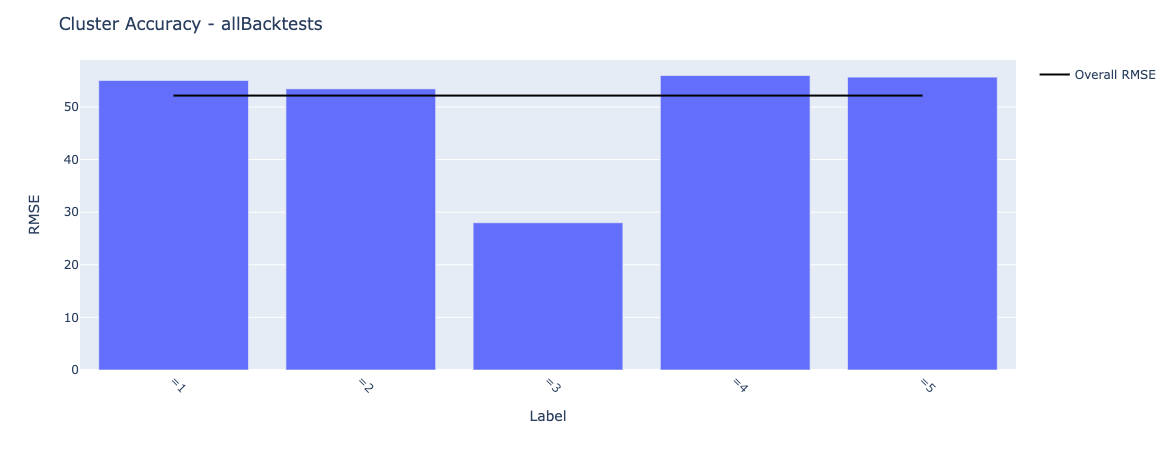

CPU times: user 16.4 s, sys: 502 ms, total: 16.9 s
Wall time: 1min 30s


In [54]:
%%time
# retrained models
cluster3_acc_rt = ts.get_cluster_acc(
    df_w_clusters_3,
    projects3_best_rt,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)
ts.plot_cluster_acc(
    cluster3_acc_rt, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse
)

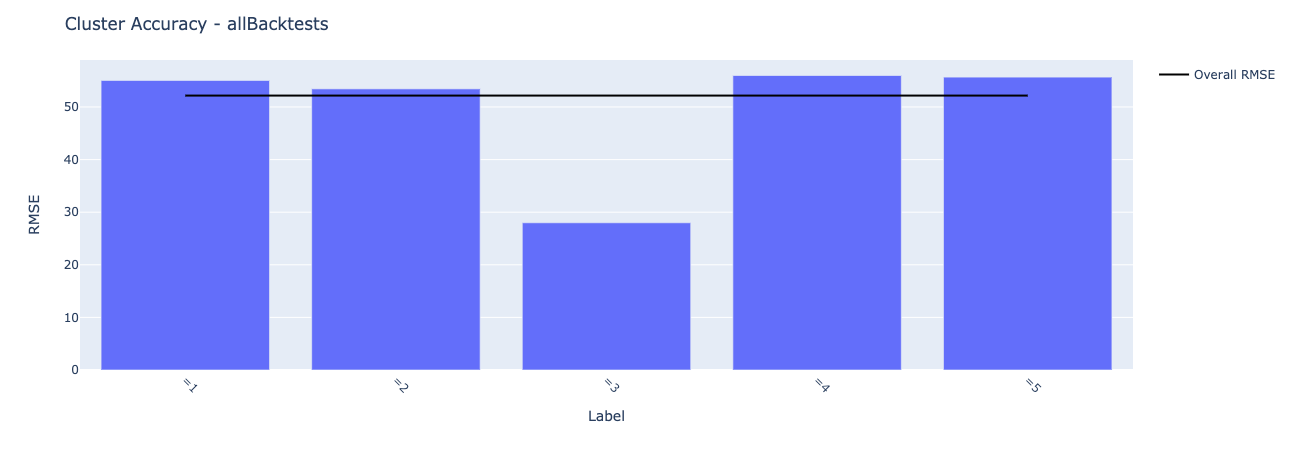

In [64]:
# comparing to original clusters results
ts.plot_cluster_acc(
    cluster3_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse
)

In [57]:
help(ts.get_series_acc)

Help on function get_series_acc in module datarobot_ts_helpers.ts_projects:

get_series_acc(df, projects, ts_settings, data_subset='allBacktests', include_blenders=True, metric=None, acc_calc=<function rmse at 0x11f7f4b00>)
    Get series-level and overall accuracy across multiple DataRobot projects
    
    df: pandas df
    projects: list
        DataRobot project object(s)
    ts_settings: dict
        Parameters for time series project
    data_subset: str
        Valid values are either holdout or allBacktests
    include_backtests: boolean (optional)
        Controls whether blender models are considered
    metric: str (optional)
        Project metric used to sort the DataRobot leaderboard
        Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
                            'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
    acc_calc: function
        Function to calculate row-level prediction accuracy. Choose from mae, rmse,

Getting series accuracy...


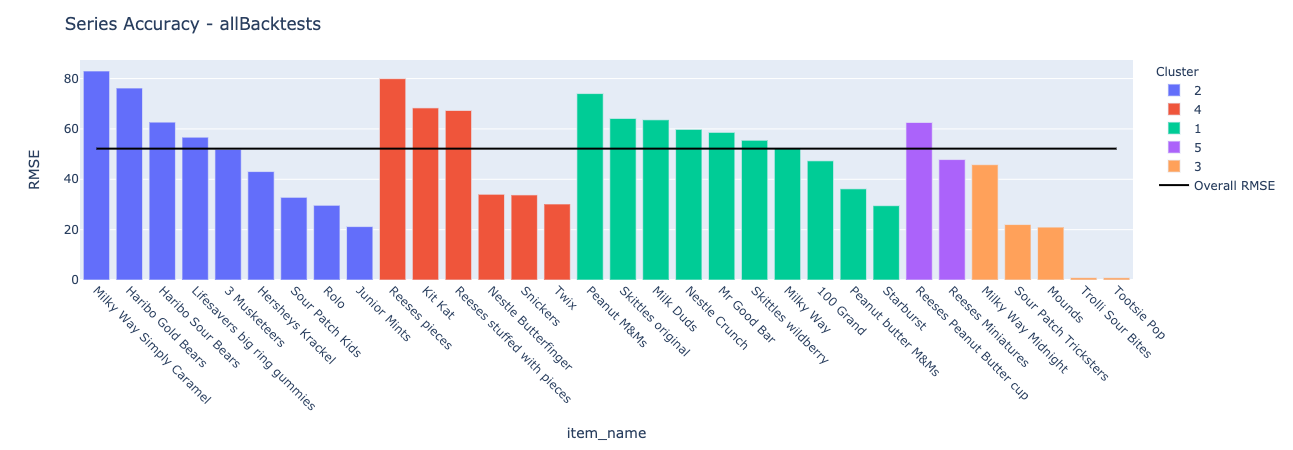

CPU times: user 16.6 s, sys: 847 ms, total: 17.5 s
Wall time: 1min 40s


In [66]:
%%time
# updated models series accuracy
series3_acc_rt = ts.get_series_acc(
    df_w_clusters_3,
    projects3_best_rt,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=ts.rmse,
)


ts.plot_series_acc(
    series3_acc_rt, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse
)

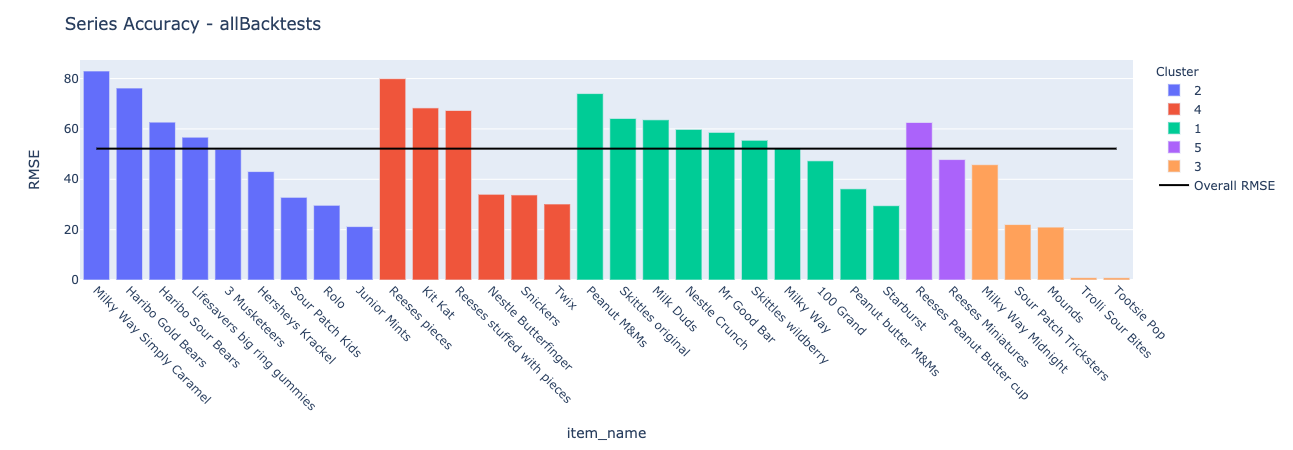

In [67]:
# compared to original series accuracy
ts.plot_series_acc(
    series3_acc, ts_settings, data_subset="allBacktests", acc_calc=ts.rmse
)

In [68]:
def get_best(df, row_idx, col1, col2):
    if df.loc[row_idx, col1] < df.loc[row_idx, col2]:
        return col1
    elif df.loc[row_idx, col1] > df.loc[row_idx, col2]:
        return col2
    else:
        return "equal"

In [69]:
pre = series3_acc[["item_name", "Series_RMSE"]].sort_values("item_name")
post = series3_acc_rt[["item_name", "Series_RMSE"]].sort_values("item_name")
pre["reduced_features_RMSE"] = post["Series_RMSE"]
pre["best"] = pre.index.tolist()
pre["best"] = pre["best"].apply(
    lambda x: get_best(pre, x, "Series_RMSE", "reduced_features_RMSE")
)
pre.head()

item_name  Series_RMSE  reduced_features_RMSE   best
0          100 Grand    47.324720              47.324720  equal
1       3 Musketeers    51.879986              51.879986  equal
2  Haribo Gold Bears    76.240345              76.240345  equal
3  Haribo Sour Bears    62.696351              62.696351  equal
4   Hersheys Krackel    43.059919              43.059919  equal

In [70]:
pre["best"].value_counts()

equal    32
Name: best, dtype: int64

### It looks like this general apporach didn't yield any improvement for this data. Lets see if we can improve this by digging deeper into the feature lists.

-----------------
# Automating Feature Selection using iterative feature thresholding

### Steps in the process
1. Start with Quick Mode
2. Get Feature Impact on the Best Model
3. Generate Top-N Feature Lists at 20%, 40%, 60%, 80% of all the features (by default 60% - 100%)
4. Train the Best Model on those reduced feature lists
5. Go take a walk while this runs
6. Plot the results
7. Automatically select the best model from each project - your model using reduced features may now top the leaderboard


In [71]:
%%time
# run this for a single project by just slicing to the list of projects to only include the DR-project of interest
# note: these have already been run, so the output errors shown below are associated with these feature lists already having been computed
one_project = ts.test_feature_selection(
    df_w_clusters_3,
    projects3_best[0:1],
    ts_settings,
    threshold_range=(0.4, 1.0),
    step_size=0.05,
)

Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 24 features M21
422 client error: {'message': 'Feature list named Top 19 features M21 already exists'}
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 16 features M21
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 13 features M21
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 11 features M21
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 10 features M21
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 12 features M13
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 5 features M87
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 4 features M87
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Fe

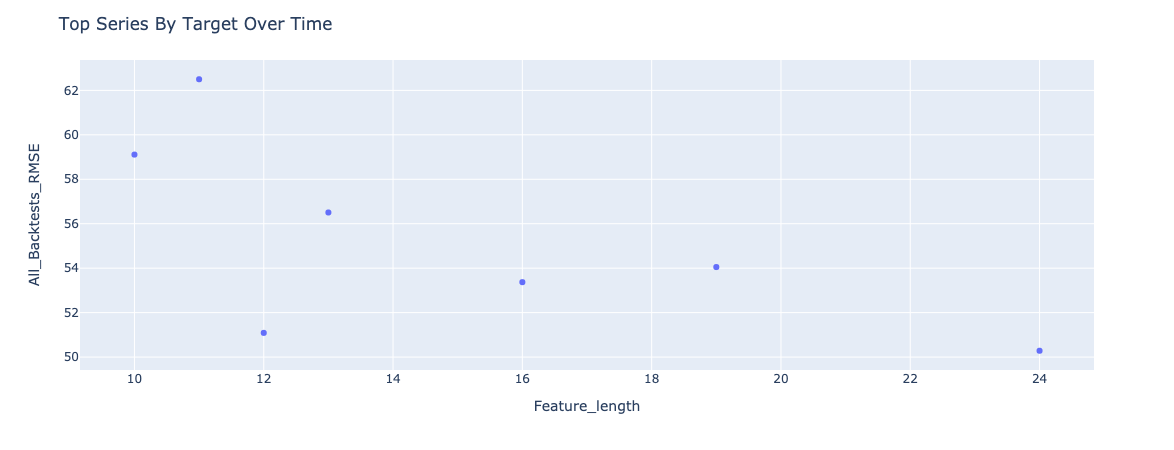

CPU times: user 60.6 ms, sys: 7.21 ms, total: 67.8 ms
Wall time: 68.5 ms


In [72]:
%%time
# plot the results
ts.plot_featurelist_learning_curve(
    one_project, data_subset="allBacktests", metric="RMSE"
)

In [ ]:
# 'test_feature_selection()' function docs
help(test_feature_selection)

In [ ]:
# 'plot_featurelist_learning_curve()' function docs
help(plot_featurelist_learning_curve)

## We see some improvement in the performance of this model on a more reduced feature list, which wasn't obtained when only a single threshold-value was used


## *** Note on retraining with reduced feature lists for some blueprints

#### - Not all blueprints will support retrainined on reduced feature lists if required features are dropped from the feature lists. This occurs commonly when a required naive-baseline feature is dropped from a feature lists. Zero-inflated models and VAR models appears to results in these errors as well, and there may be other unknown blueprint-specific interactions or limitations.

#### - By default, these functions will take the highest-ranked non-blender model on the leaderboard. Optionally, you can put the leaderboard rank (starting from 1) as a parameter (model_rank= n) and it will take the number 'n' ranked model for feature selection testing.

In [ ]:
# get a model based on leaderboard rank
ts.get_ranked_model(
    project=projects3_best[4], model_rank=4, metric="RMSE", data_subset="allBacktests"
)

#### 'get_ranked_model()' function docs &darr;

In [ ]:
# get_ranked_model()

# """
# project: project object
#     DataRobot project
# model_rank: int
#     None if top model, model leaderboard rank if any model other than top desired
# metric: str (optional)
#     Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
#                         'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
# data_subset: str (optional)
#     Can be set to either backtest_1, allBacktests or holdout

# Returns:
# --------
# model object from a DataRobot project

## These checks have been automated in the function that allows you to run this for multiple DataRobot projects, as below:

In [ ]:
%%time
# perform this for all of the projects
# note: this has already been run for these projects (projects3_best), so outputs will show an error that these featurelist already exist
all_projects = ts.run_feature_selection_projects(
    df_w_clusters_3,
    projects3_best,
    ts_settings,
    threshold_range=(0.4, 1.0),
    step_size=0.05,
)
all_projects.shape

### Plot the results:

In [ ]:
%%time
ts.plot_all_featurelist_curves(
    all_projects, ts_settings, data_subset="allBacktests", metric="RMSE"
)

#### 'plot_all_featurelist_curves()' function docs &darr;

def plot_all_featurelist_curves(df, ts_settings, data_subset= 'allBacktests', metric= 'RMSE'):

    """
    Plot all reduced featurelists on the same curve
    
    df: pandas df
    ts_settings: dict
        Parameters for DR datetime projects
    data_subset: str
        data to be used for plotting
    metric: str
        metric used for plotting
    """


### Evaluation of automated feature list reduction for these projects provides variable lift, with largest increase of ~10% decrease in RMSE as in two DataRobot projects (Cluster 1 FD 16-30, Cluster 5 FD 16-30). Other projects have limited or no improvement.

--------
# Run the Repo...

### When all else fails and you've got time, then you can consider running many models from the repository. By default, this function will use the featurelist from the DataRobot recommended blueprint. If you want to be 'insane', you can run the repo on the featurelist from the top-5 blueprints on the leaderboard.

In [ ]:
# use a sledgehammer...
# the code runs quite fast, and then you have to wait for all of the blueprints to train
ts.run_repository_models(
    projects3_best,
    n_bps=None,
    insane=False,
    exclude=["Mean", "Eureqa", "Keras", "VARMAX"],
)

#### 'run_repository_models()' function docs &darr;

def run_repository_models(projects, n_bps=None, insane= False, exclude=['Mean', 'Eureqa', 'Keras', 'VARMAX']):
    """
    Run blueprints from the repository using the feature list from the DataRobot recommended models

    projects: list
        DataRobot project object(s)
    n_bps: int
        Number of blueprints from repository to return
    insane: bool
        If True, run repo on featurelist from top 5 blueprints on leaderboard, if False run on recommended model featurelist
    exclude: list
        DataRobot model types to exclude from running
    """

---------------
# Creating Time Series blenders

### In some situations, especially as viewed above, there many be value in creating time series model blenders. Blenders are more challenging for the iterative modeling because of restrictions and challenges associated with retraining and feature selection. But blending final models can yield additional performance at the cost of complexity and slower prediction speeds.

### Of particular interest are forecast distance blenders, which allow you to improve weak model performance that might be uncovered by evaluating absolute or relative accuracy over time (as in the above plots).

In [ ]:
%%time
# train a time-series blender model for a single project by either selecting how many of the top leaderboard models (n_models)
# select from FORECAST_DISTANCE_AVG, AVERAGE, MEDIAN, FORECAST_DISTANCE_ENET blender options
ts.train_timeseries_blender(
    project=projects3_best[0],
    models=None,
    n_models=3,
    blender_method="AVERAGE",
    data_subset="allBacktests",
)

In [ ]:
%%time
# or train a time-series blender by providing specific model ids in a list
select_models = [
    "5ed8f71a2bbcef6774df34ee",
    "5ed8f5e2c70b581d6cb6ff5c",
    "5ed8f5e2c70b581d6cb6ff62",
]
ts.train_timeseries_blender(
    project=projects3_best[0],
    models=select_models,
    n_models=None,
    blender_method="MEDIAN",
    data_subset="allBacktests",
)

In [ ]:
%%time
# You can also create time-series blenders for many projects
# either explicitly define models for each project within a list: list of lists where each-sublist contains the model-ids that correspond to the project with the same index in the project list
# or select how many of the top-models you want DataRobot to automatically blend
ts.train_timeseries_blender_projects(
    projects3_best, models=None, n_models=3, blender_method="FORECAST_DISTANCE_AVG"
)

In [ ]:
%%time
ts.wait_for_jobs_to_process(projects3_best)
ts.compute_backtests(projects3_best)

--------------
# Analysis of Performance Improvement

## Now that we've completed the retraining, let's get the best models and plot the performance to see if we've improved much over the original models

In [19]:
%%time
ts.compute_backtests(
    projects3_best,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=True,
    metric="RMSE",
)
project3_scores_retrained2 = ts.get_or_request_backtest_scores(
    projects3_best,
    n_models=5,
    data_subset="allBacktests",
    include_blenders=True,
    metric="RMSE",
)

scores3_best_retrained2 = ts.filter_best_fdw_scores(
    project3_scores_retrained2, col_error="All_Backtests_RMSE"
)
projects3_best_retrained2 = ts.filter_best_fdw_projects(
    project3_scores_retrained2, projects3_best, col_error="All_Backtests_RMSE"
)

All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5
All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5
All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:1-15_FDW:-62_Cluster-4
All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-4
All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-3
All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-3
All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-2
All available backtests have been submitted for scoring for project TS_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2
All available backtests have been submitted for scoring for project 

In [276]:
# merge the results of the original and retrained models
comparison = scores3_best.merge(
    scores3_best_retrained2, how="inner", on="Project_ID", suffixes=("_Orig", "_RT")
)

# deal with the list values in the 'All_Backtests*' columns
for column in [x for x in comparison.columns.tolist() if "All" in str(x)]:
    try:
        comparison[column] = comparison[column].apply(
            lambda x: [sum(x) / len(x) for x in x if x != None][0]
        )
    except:
        pass

# determine which approach was better
comparison["best"] = comparison.index.tolist()
comparison["best"] = comparison["best"].apply(
    lambda x: get_best(
        comparison, x, "All_Backtests_RMSE_Orig", "All_Backtests_RMSE_RT"
    )
)

# get the counts
comparison["best"].value_counts()

All_Backtests_RMSE_RT      8
All_Backtests_RMSE_Orig    1
equal                      1
Name: best, dtype: int64

### Looks like the retraining did result in a better models relative to the original testing for most clusters. Lets see how significant a difference this is:

Getting cluster accuracy...


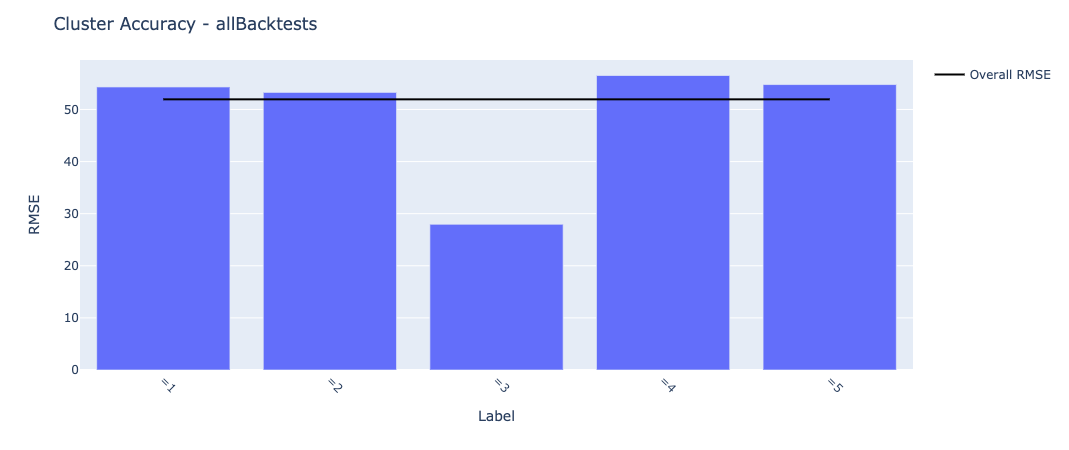

In [277]:
# retrained models
cluster3_acc_retrained2 = ts.get_cluster_acc(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    data_subset="allBacktests",
    include_blenders=False,
    metric="RMSE",
    acc_calc=rmse,
)
ts.plot_cluster_acc(
    cluster3_acc_retrained2, ts_settings, data_subset="allBacktests", acc_calc=rmse
)

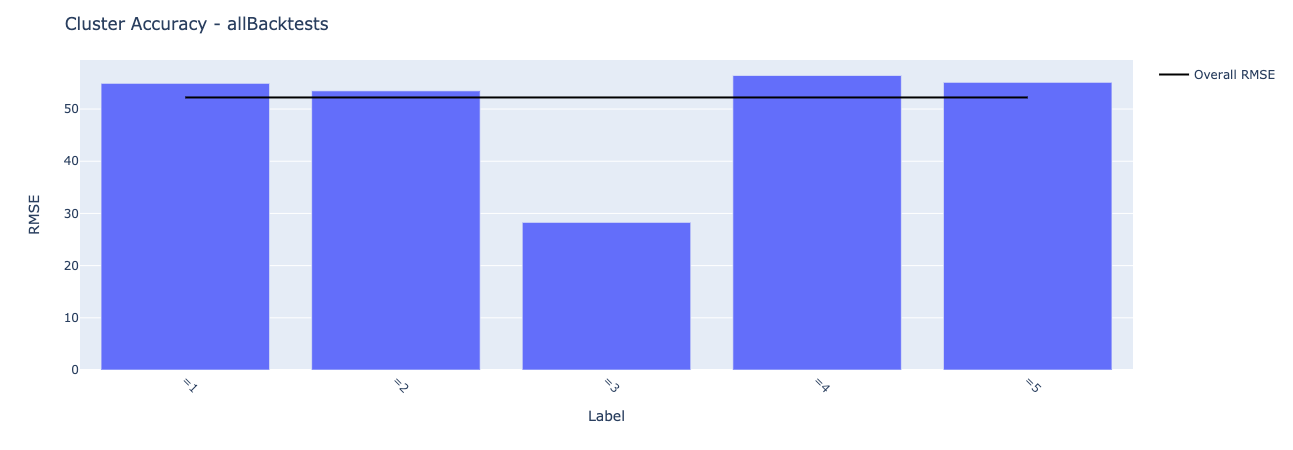

In [278]:
# original models

ts.plot_cluster_acc(
    cluster3_acc, ts_settings, data_subset="allBacktests", acc_calc=rmse
)

### Tiny (0.2 - 0.6 RMSE) performance improvements across all clusters, not much value provided for the extra compute in this instance. It may provide more lift with other datasets and modeling approaches.


----------------
# Getting training predictions

### In the model evaluation and interation process, you may want the training predictions. These can easily be obtained via a function 'get_preds_and_actuals':

In [20]:
%%time
# get predictions for all series
test_predictions = ts.get_preds_and_actuals(
    df=df_w_clusters_3,
    projects=projects3_best_retrained2,
    ts_settings=ts_settings,
    include_blenders=True,
)

CPU times: user 12.6 s, sys: 286 ms, total: 12.8 s
Wall time: 2min 29s


#### 'get_preds_and_actuals()' function docs &darr;

def _cut_series_by_rank(df, ts_settings, n=1, top=True):
    """
    Select top-n or bottom-n series by rank
    
    df: pandas df
    ts_settings: dict
        Parameters for datetime DR projects
    n: int
        number of series to select
    top: bool
        Select highest (True) or lowest series (False)
    
    Returns:
    --------
    pandas df
    """
    
    df_agg = df.groupby(ts_settings['series_id']).mean()
    selected_series_names = (
        df_agg.sort_values(by=ts_settings['target'], ascending=top).tail(n).index.values
    )

    return selected_series_names 


In [21]:
test_predictions.head()

item_name       date  package_id_min  package_id_max  package_id_unique  \
0  100 Grand 2018-12-21    1.700004e+09    1.700004e+09                3.0   
1  100 Grand 2018-12-21    1.700004e+09    1.700004e+09                3.0   
2  100 Grand 2018-12-21    1.700004e+09    1.700004e+09                3.0   
3  100 Grand 2018-12-21    1.700004e+09    1.700004e+09                3.0   
4  100 Grand 2018-12-21    1.700004e+09    1.700004e+09                3.0   

      campaign_min     campaign_max  campaign_unique  qty_min  qty_mean  \
0  discount_type_2  discount_type_1              4.0     1.96     4.004   
1  discount_type_2  discount_type_1              4.0     1.96     4.004   
2  discount_type_2  discount_type_1              4.0     1.96     4.004   
3  discount_type_2  discount_type_1              4.0     1.96     4.004   
4  discount_type_2  discount_type_1              4.0     1.96     4.004   

   qty_max  qty_stdev  qty_unique  qty_sum  unit_price_min  unit_price_mean  \
0     7.84   1.954984        10.0    80.08            0.03            1.898   
1     7.84   1.954984        10.0    80.08            0.03            1.898   
2     7.84   1.954984        10.0    80.08            0.03            1.898   
3     7.84   1.954984        10.0    80.08            0.03            1.898   
4     7.84   1.954984        10.0    80.08            0.03            1.898   

   unit_price_max  unit_price_stdev  unit_price_unique  unit_price_sum  \
0             3.0          0.715097               15.0           37.96   
1             3.0          0.715097               15.0           37.96   
2             3.0          0.715097               15.0           37.96   
3             3.0          0.715097               15.0           37.96   
4             3.0          0.715097               15.0           37.96   

   sale_amount_min  sale_amount_mean  sale_amount_max  sale_amount_stdev  \
0             0.06             7.437            16.87           3.865821   
1             0.06             7.437            16.87           3.865821   
2             0.06             7.437            16.87           3.865821   
3             0.06             7.437            16.87           3.865821   
4             0.06             7.437            16.87           3.865821   

   sale_amount_unique  sale_amount_sum  day store_category category  \
0                18.0           148.74  Fri         Type_B   Retail   
1                18.0           148.74  Fri         Type_B   Retail   
2                18.0           148.74  Fri         Type_B   Retail   
3                18.0           148.74  Fri         Type_B   Retail   
4                18.0           148.74  Fri         Type_B   Retail   

  transaction  aggregated_total_count  metro_area  county_1  \
0        Good                    20.0         NaN       NaN   
1        Good                    20.0         NaN       NaN   
2        Good                    20.0         NaN       NaN   
3        Good                    20.0         NaN       NaN   
4        Good                    20.0         NaN       NaN   

   total_market_sales  Cluster  sale_amount_sum_mean  sale_amount_sum_std  \
0                 NaN        1              93.07125             74.06183   
1                 NaN        1              93.07125             74.06183   
2                 NaN        1              93.07125             74.06183   
3                 NaN        1              93.07125             74.06183   
4                 NaN        1              93.07125             74.06183   

   sale_amount_sum_min  sale_amount_sum_max   row_id partition_id  prediction  \
0                 9.64               200.79  11175.0          2.0   75.474117   
1                 9.64               200.79  11176.0          2.0   75.168813   
2                 9.64               200.79  11177.0          2.0   74.264294   
3                 9.64               200.79  11178.0          2.0   72.987545   
4                 9.64          

These downloaded actuals and predictions from the training data provide info on the DR Project, Model, and the predictions for every forecast distance for all dates. Because we have overlap on forecast point and forecast distances, we generally have multiple predictions for each date. 

Generally, you will use the lowest forecast distance to serve as the prediction for a given date, but you can imagine scenarios in which you may actually prefer to use a different forecast distance prediction for date (if for example it was more accurate).

## It may also be relevant to plot the actuals and predictions.

####  The following 'plot_preds_and_actuals()' function can plot the average across all series, the top series, a named series, plotting individual forecast distances, and allows for control over the aggregation of predictions for a single date from forecast distance predictions

#### 'plot_preds_and_actuals()' function docs &darr;

plot_preds_and_actuals(
    df, 
    projects, 
    ts_settings, 
    fd_range=None, 
    fd_agg= 'mean', 
    fd= None, 
    average= True, 
    series_name= None, 
    top=None, 
    data_subset= 'allBacktests', 
    include_blenders=False, 
    metric= None, 
    acc_calc=rmse):

    """
    Get series-level and overall accuracy across multiple DataRobot projects

    df: pandas df
    projects: list
        DataRobot project object(s)
    ts_settings: dict
        Parameters for time series project
    fd_range: tuple of ints
        FD start and stop for plotting, None will select all FD
    fd_agg: str
        Aggregation of multiple predictions for a date, accepts 'min', 'max', 'mean'
    fd: int
        Specify FD to plot predictions vs actuals using only that FD
    average: bool
        If plotting average values or individual series
    series_name: str
        Series name (str) to plot
    top: bool
        Plot highest or lowest ordered series by mean target value
    data_subset: str
        Valid values are either holdout or allBacktests
    include_backtests: boolean (optional)
        Controls whether blender models are considered
    metric: str (optional)
        Project metric used to sort the DataRobot leaderboard
        Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
                            'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
    acc_calc: function
        Function to calculate row-level prediction accuracy. Choose from mae, rmse, mape, smape, gamma, poission, and tweedie
        
    Returns:
    --------
    Plotly lineplot
    """

Getting series predictions from DataRobot...


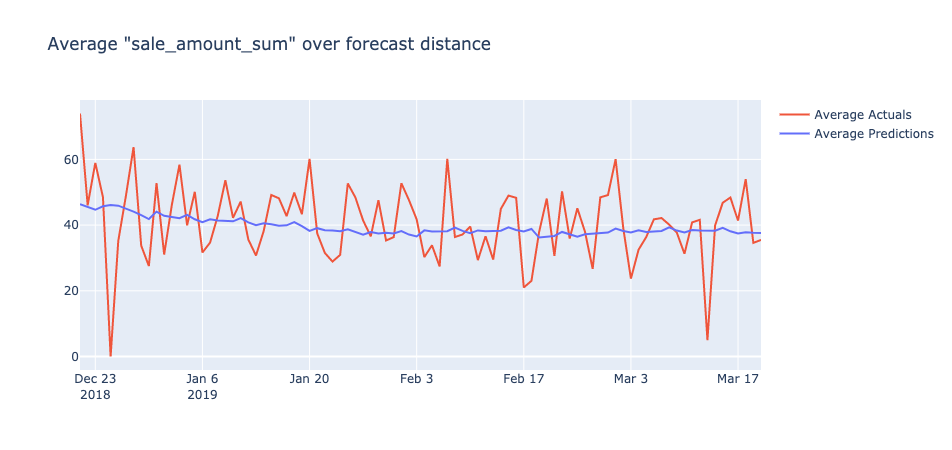

CPU times: user 16.8 s, sys: 675 ms, total: 17.5 s
Wall time: 3min 10s


In [281]:
%%time
# plot the average for all series
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="mean",
    fd=None,
    average=True,
    series_name=None,
    top=True,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


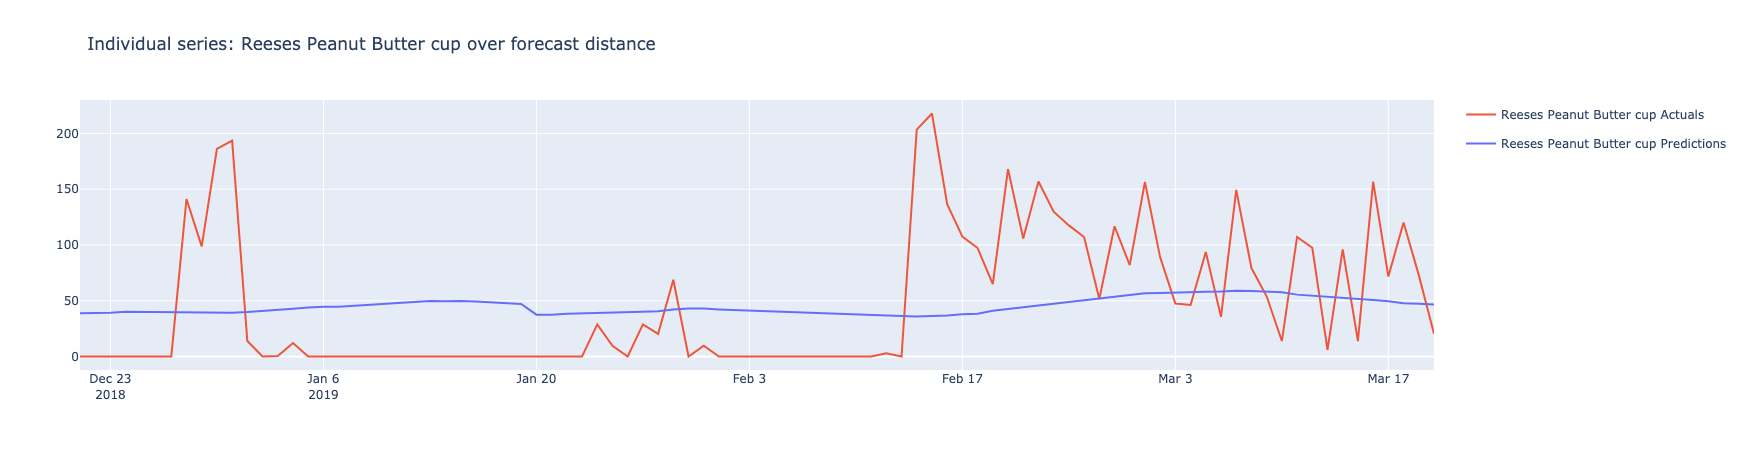

CPU times: user 13.4 s, sys: 259 ms, total: 13.7 s
Wall time: 3min 58s


In [282]:
%%time
# plot the series with the highest average target value (or lowest uisng top= False)
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="mean",
    fd=None,
    average=False,
    series_name=None,
    top=True,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


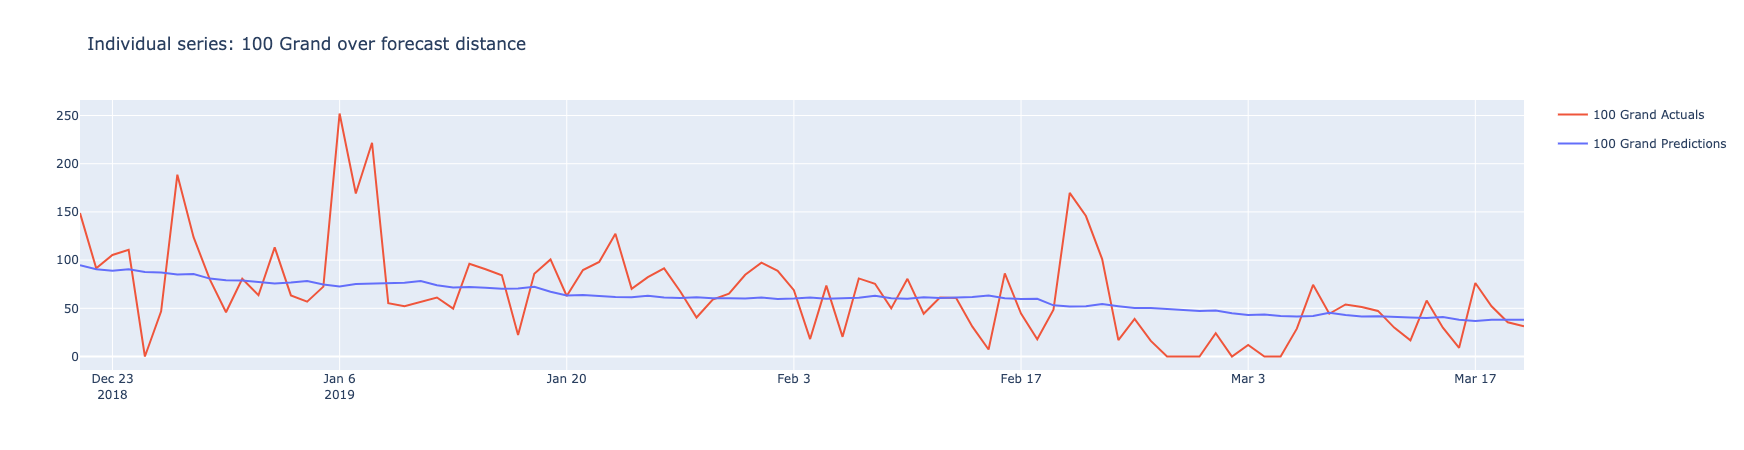

In [283]:
# plot a specific series by name: '100 Grand'
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="mean",
    fd=None,
    average=False,
    series_name="100 Grand",
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


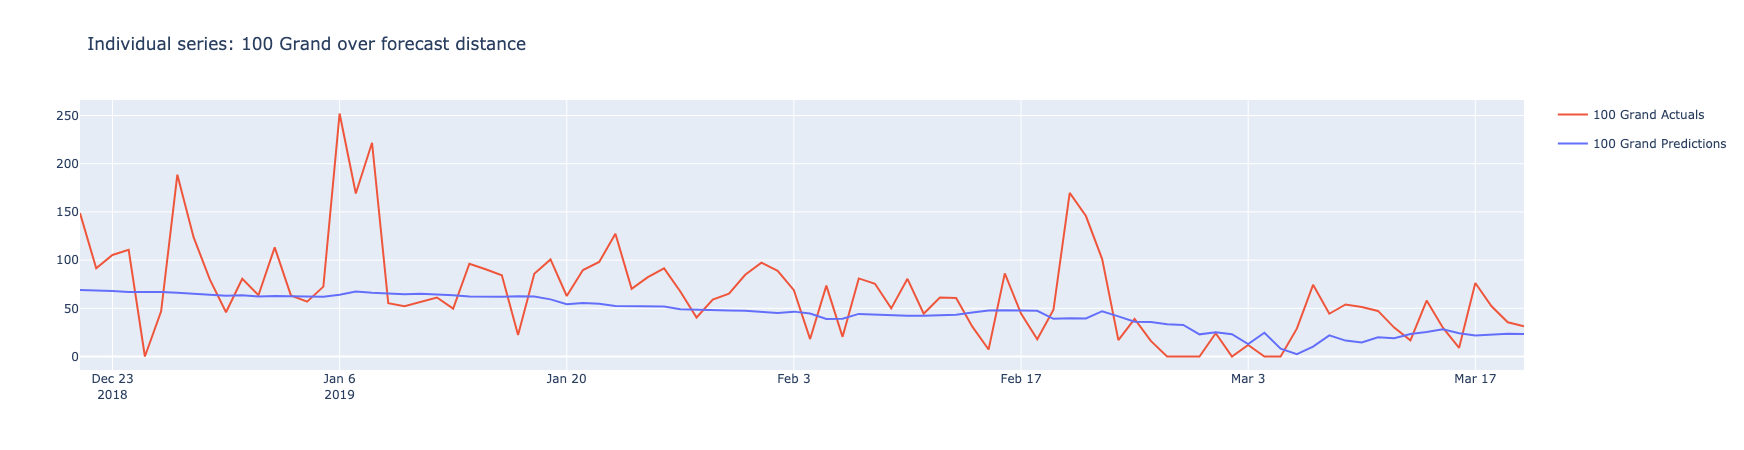

In [284]:
# plot a specific series by name: '100 Grand'
# plot minimum prediction from all fd
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="min",
    fd=None,
    average=False,
    series_name="100 Grand",
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


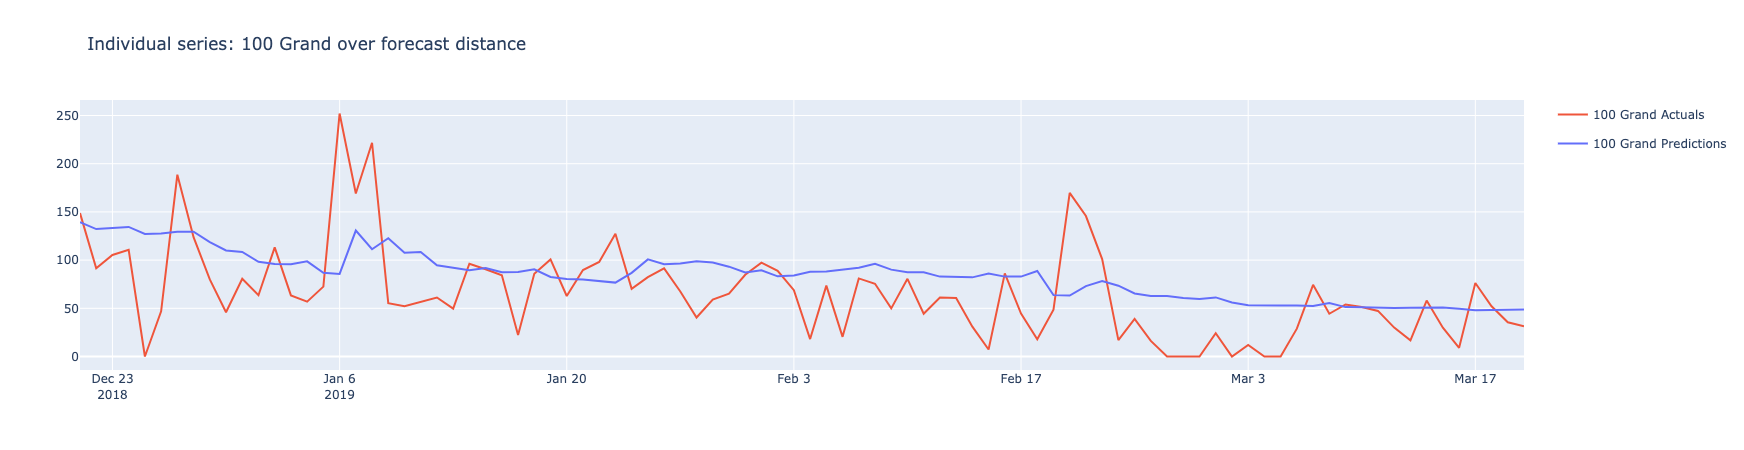

In [285]:
# plot a specific series by name: '100 Grand'
# plot maximum prediction from all fd
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="max",
    fd=None,
    average=False,
    series_name="100 Grand",
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


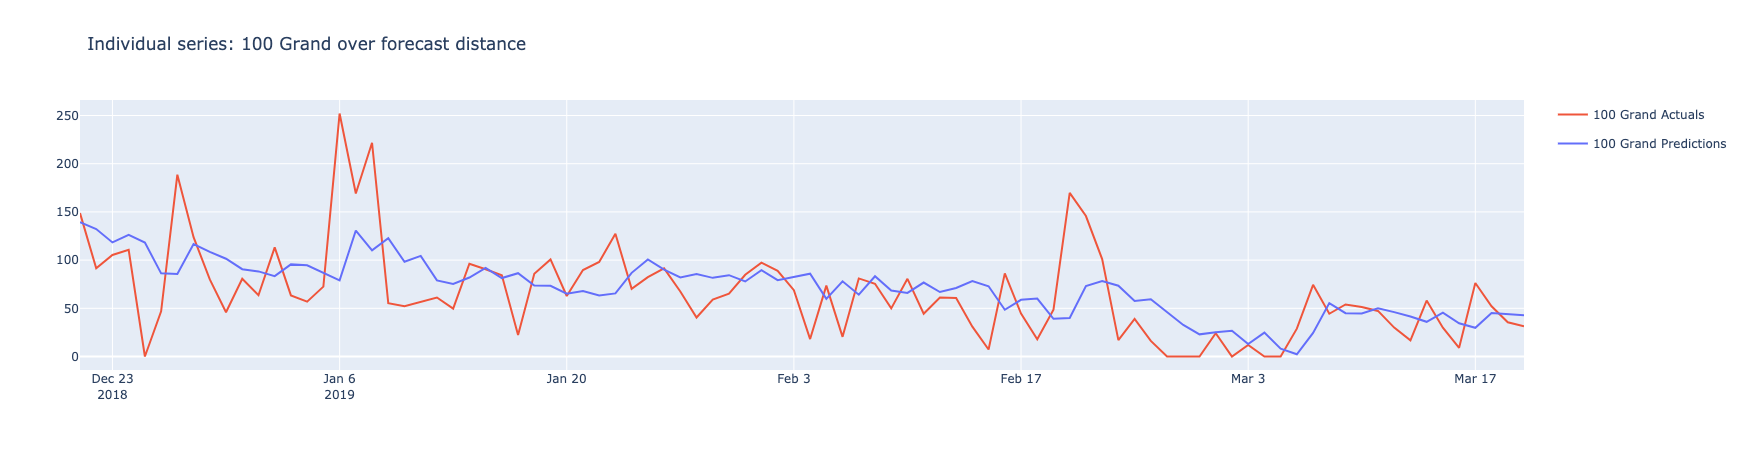

In [286]:
# plot a specific series by name: '100 Grand'
# plot only the fd 1 predictions
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="mean",
    fd=1,
    average=False,
    series_name="100 Grand",
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


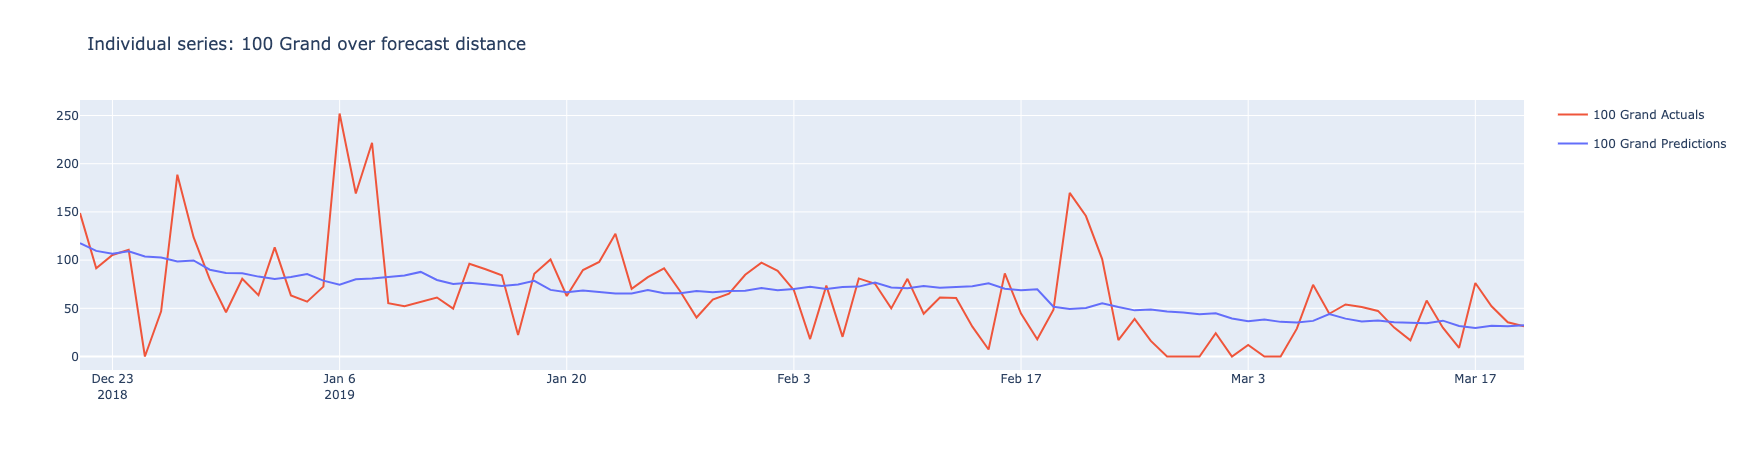

In [287]:
# plot a specific series by name: '100 Grand'
# plot only the first 15 fds (fd_range= (1,15))
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=(1, 15),
    fd_agg="mean",
    fd=None,
    average=False,
    series_name="100 Grand",
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


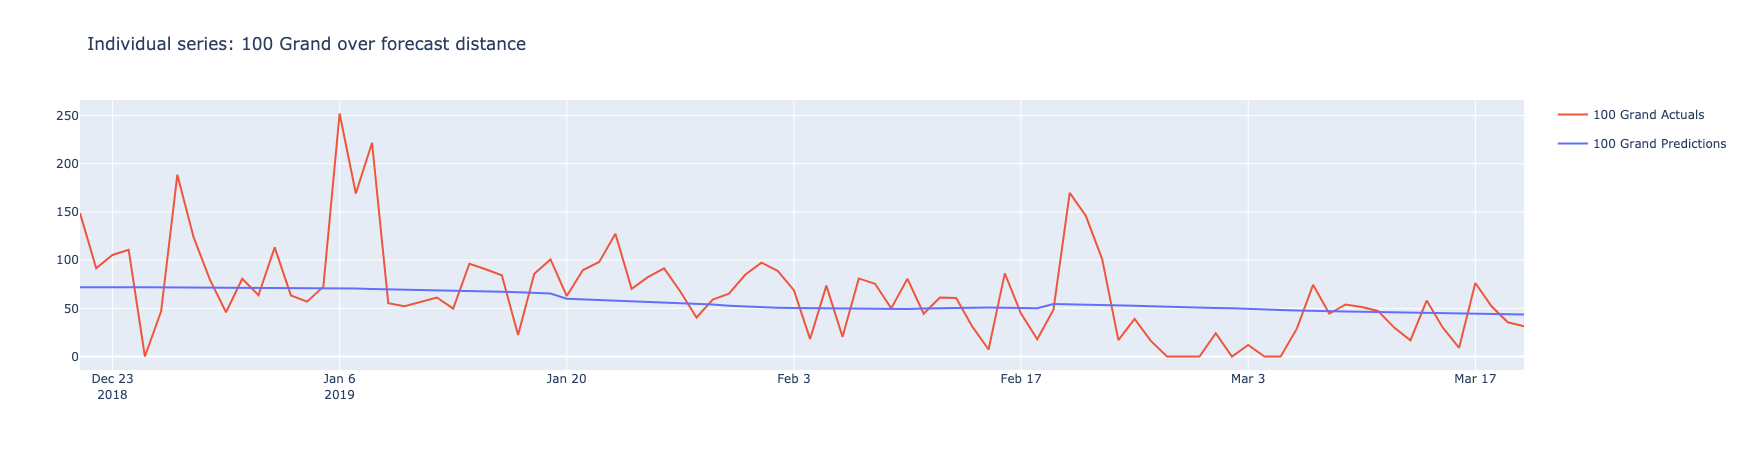

In [288]:
# plot a specific series by name: '100 Grand'
# plot only the last 15 fds (fd_range= (16,30))
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=(16, 30),
    fd_agg="mean",
    fd=None,
    average=False,
    series_name="100 Grand",
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

## What do these actuals and predictions look like for the best, worst, and representative of average series look like?

In [290]:
best_series = "Nestle Butterfinger"
worst_series = "Skittles original"
representative_series = "Snickers"

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


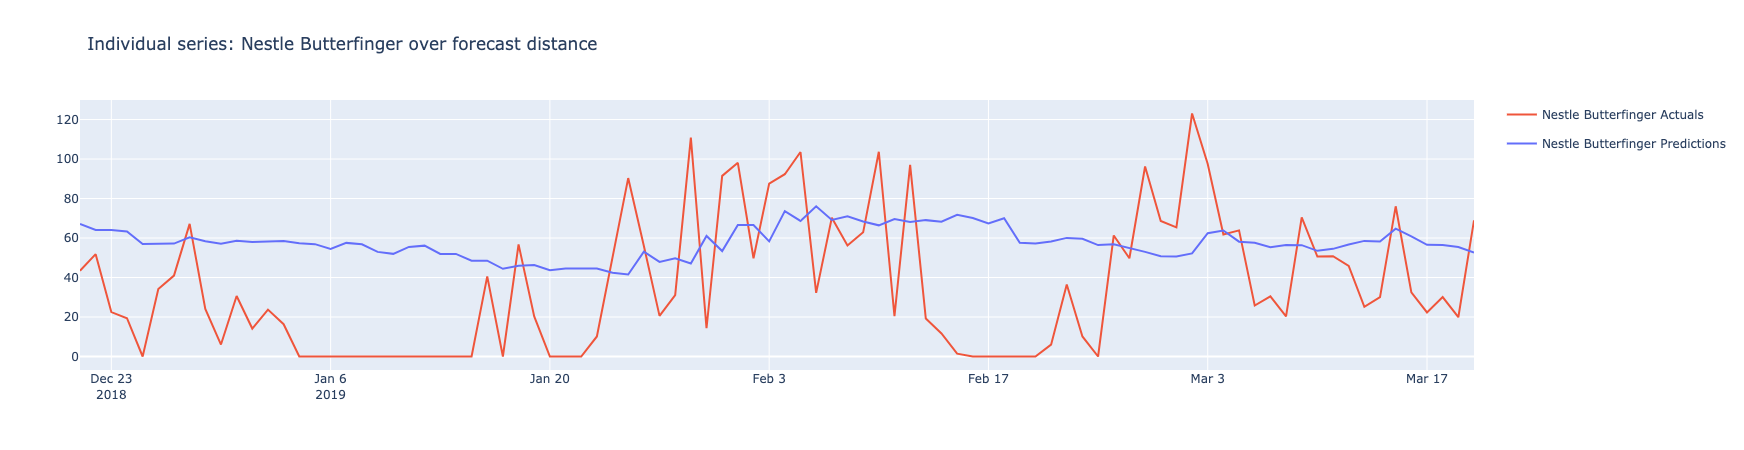

In [291]:
# plot a common, high performing series
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="max",
    fd=None,
    average=False,
    series_name=best_series,
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


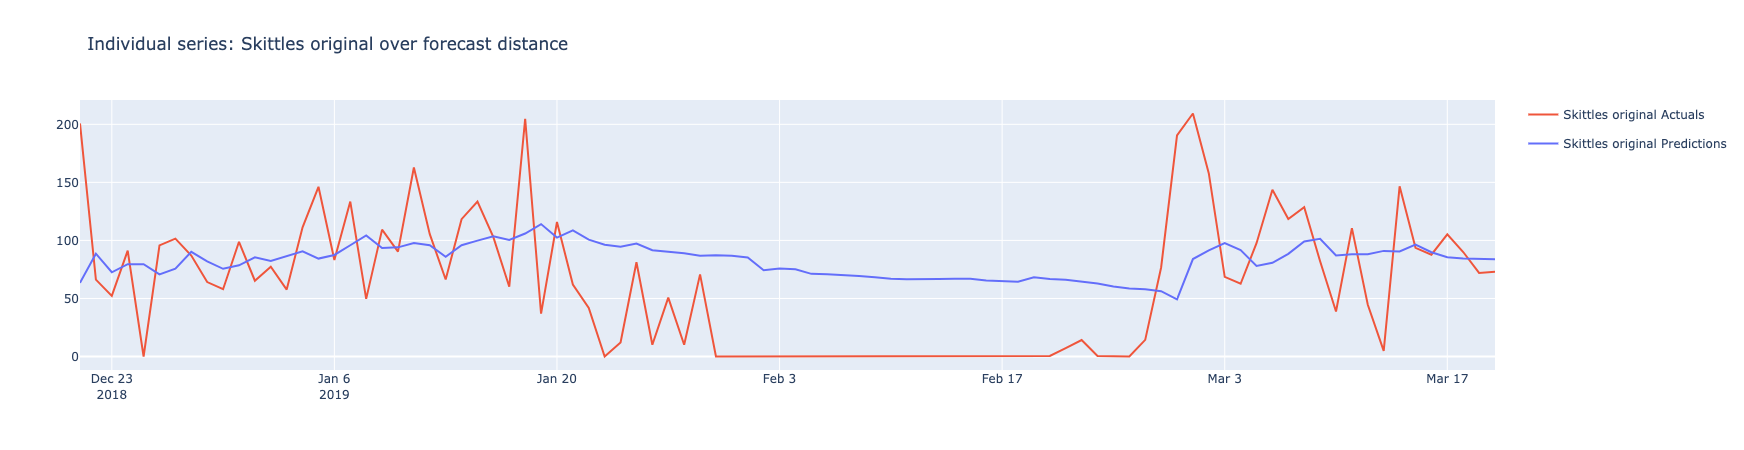

In [292]:
# plot the worst performing series
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="max",
    fd=None,
    average=False,
    series_name=worst_series,
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


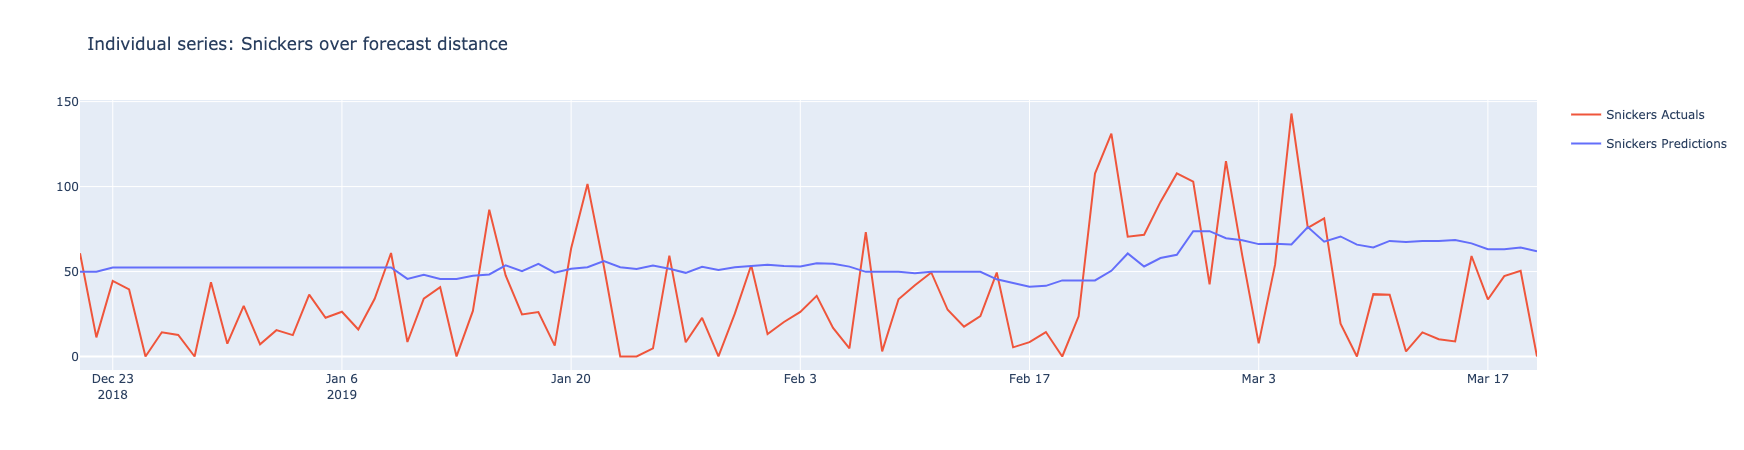

In [293]:
# plot the representative performing series
ts.plot_preds_and_actuals(
    df_w_clusters_3,
    projects3_best_retrained2,
    ts_settings,
    fd_range=None,
    fd_agg="max",
    fd=None,
    average=False,
    series_name=representative_series,
    top=False,
    data_subset="allBacktests",
    include_blenders=True,
    metric=None,
    acc_calc=rmse,
)

### Looking at these plots, we see that the predictions are not particularly strong, and are essentially just a moving average. As we've seen above, the models produced for this dataset because of the relatively small size of the data, presence of short series, and high volatility suggests this dataset may not support strongly predictive models to match the extreme values seen on a daily basis.

----------------
# Evaluating performance on Forecast Distances and Accuracy over Time



#### 'plot_fd_accuracy_by_cluster()' function docs &darr;

plot_fd_accuracy(df, projects, ts_settings, data_subset='allBacktests', metric='RMSE'):
    
    """
    Plots accuracy over forecast distance

    df: pandas df
        Input data
    projects: list
        List of DataRobot datetime projects
    ts_settings: dict
        Parameters for time series project
    data_subset: str
        Choose from either holdout or allBacktests
    metric: str (optional)
        Project metric used to sort the DataRobot leaderboard
        Choose from list of 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
                            'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'

    Returns:
    --------
    Plotly lineplot
    """

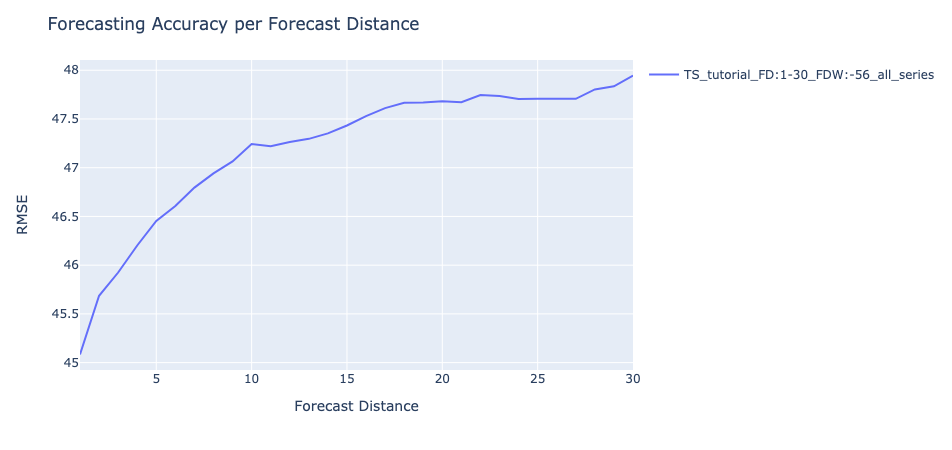

In [99]:
# Project 1
ts.plot_fd_accuracy_by_cluster(
    df_w_clusters,
    project_scores,
    projects_best,
    ts_settings,
    data_subset="allBacktests",
    metric="RMSE",
)

#### When evaluating accuracy over time, it may be relevant to select a 'relative to baseline' metric (such as MAE, MAPE, or SMAPE) to understand how well the model performs over time. This provides a context by which we can understand how or why our models might not have consistent performance over time. Generally, you would expect that a model becomes less accurate over time, but that does not always hold with different data sets.

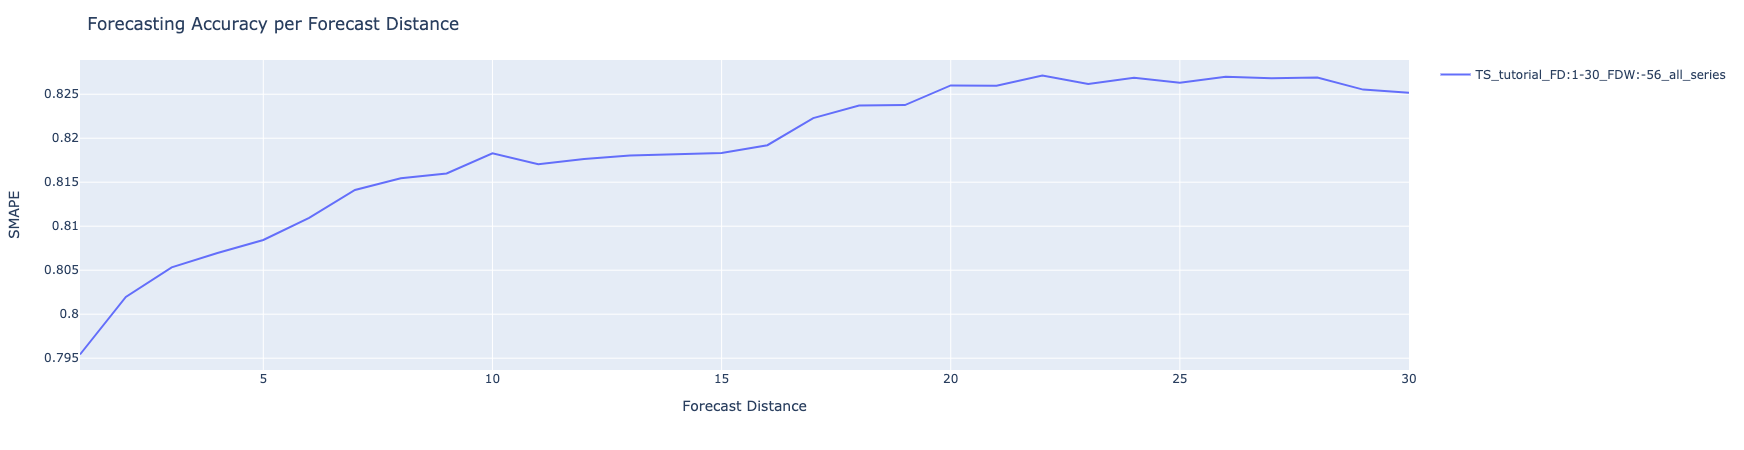

In [100]:
# Project 1
ts.plot_fd_accuracy_by_cluster(
    df_w_clusters,
    project_scores,
    projects_best,
    ts_settings,
    data_subset="allBacktests",
    metric="SMAPE",
)

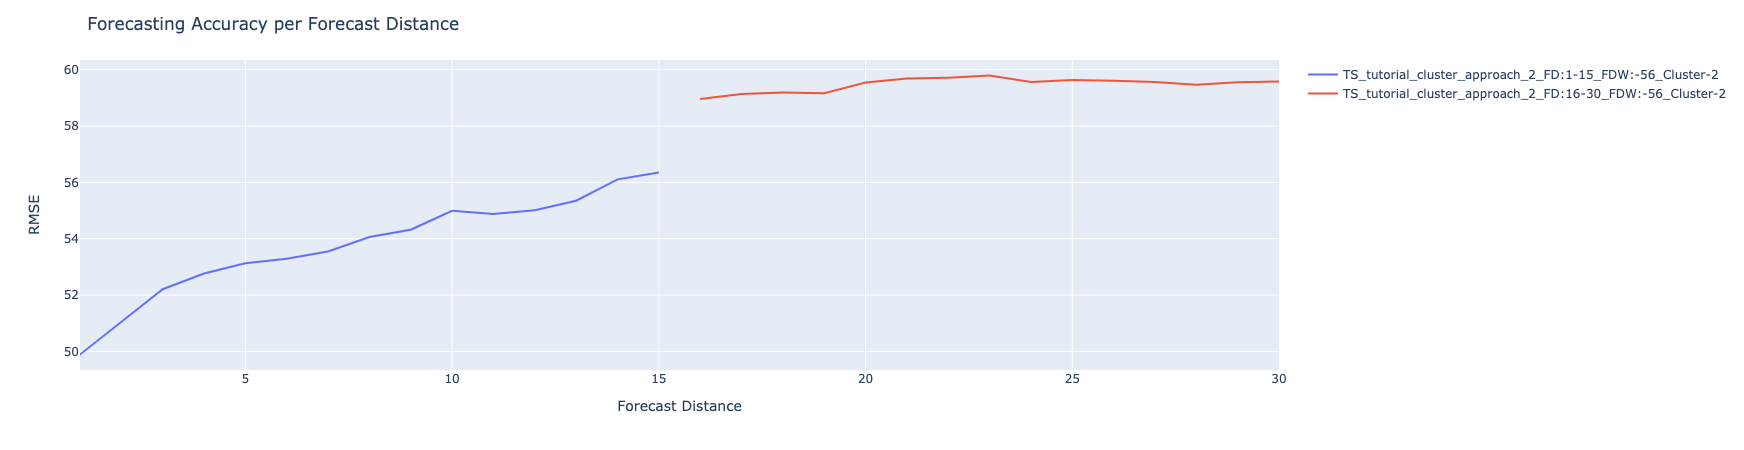

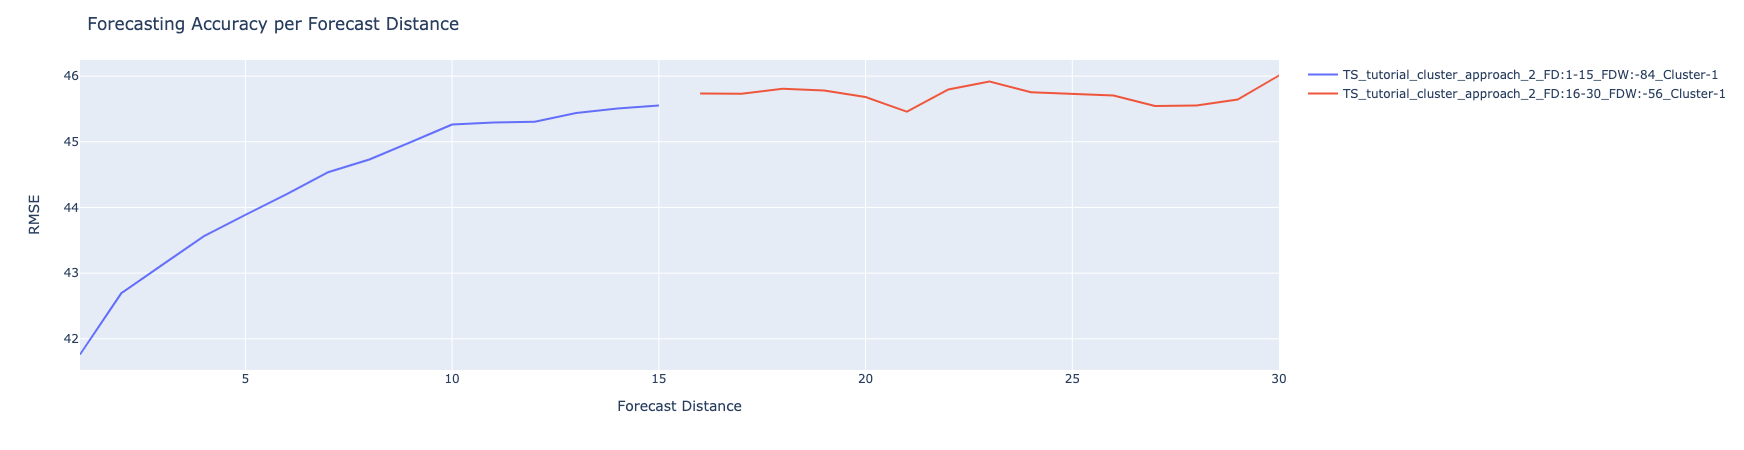

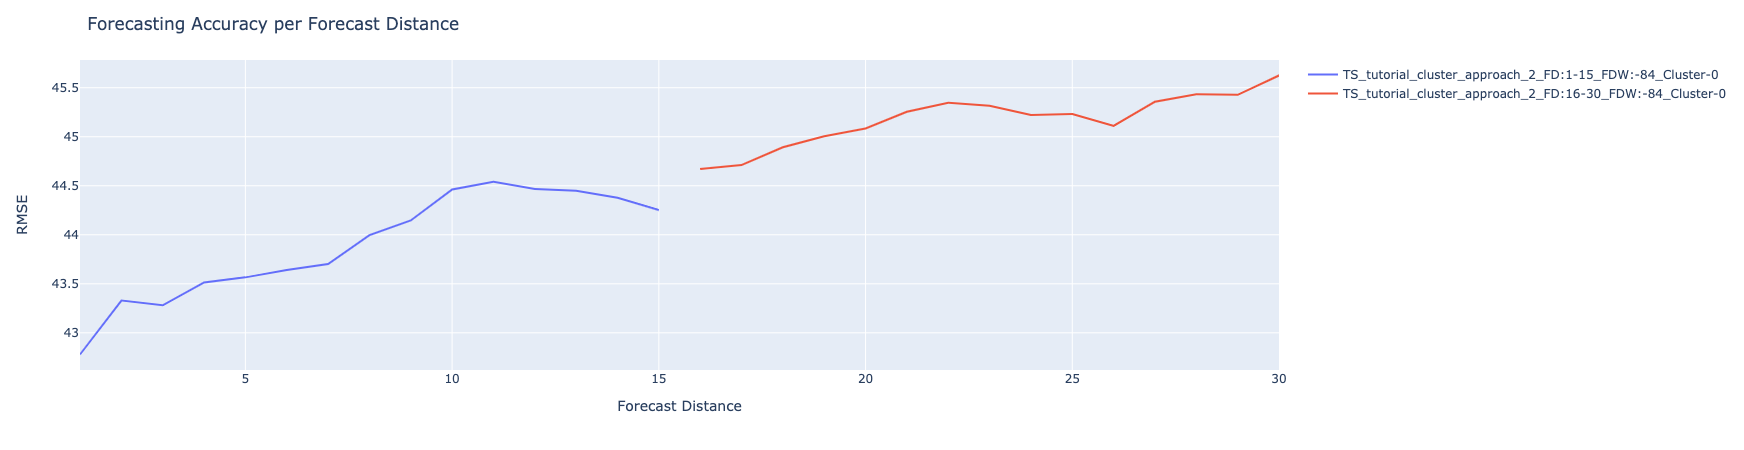

In [101]:
# Project 2
ts.plot_fd_accuracy_by_cluster(
    df_w_clusters_2,
    project2_scores,
    projects2_best,
    ts_settings,
    data_subset="allBacktests",
    metric="RMSE",
)

### Evaluating Accuracy over Time is useful both with an absolute metric (like RMSE) and using a baseline-relevant metric (like MAE, MAPE, SMAPE). Interesting insights about the fundamental sales ('system') can be learned from the performance of a naive baseline. 
- Examine 'Cluster 2' in the above RMSE plot and below SMAPE plot.
- Why does the relative performance of the model appear better in the FD:16-30 model using SMAPE, dispite having a worse RMSE than FD:1-15?
- Why does the relative performance of FD:1-15 decline so quickly from FD 1 to 5 and 5 to 15? Are there other factors we could model?

### Model performance relative to a baseline can help highlight where there are potentially other improvements to be made in the data (by enhanced training data or potentially model improvement). It also allows for comparison to different models that may give better relative performance in different forecasting windows.

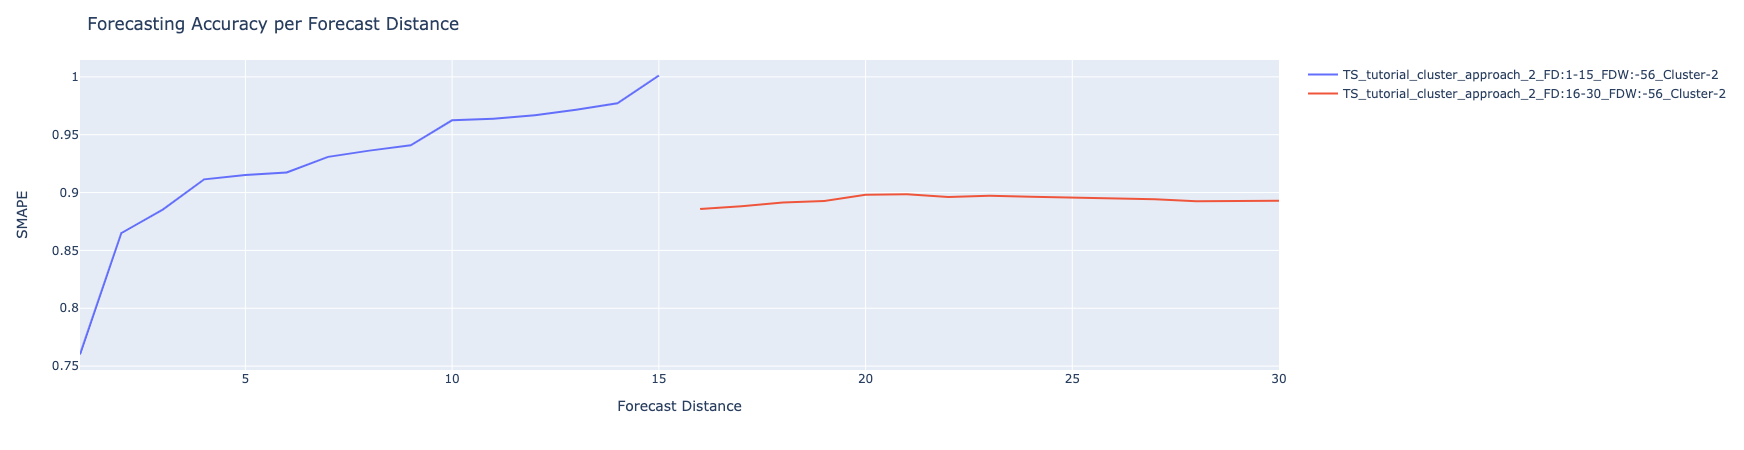

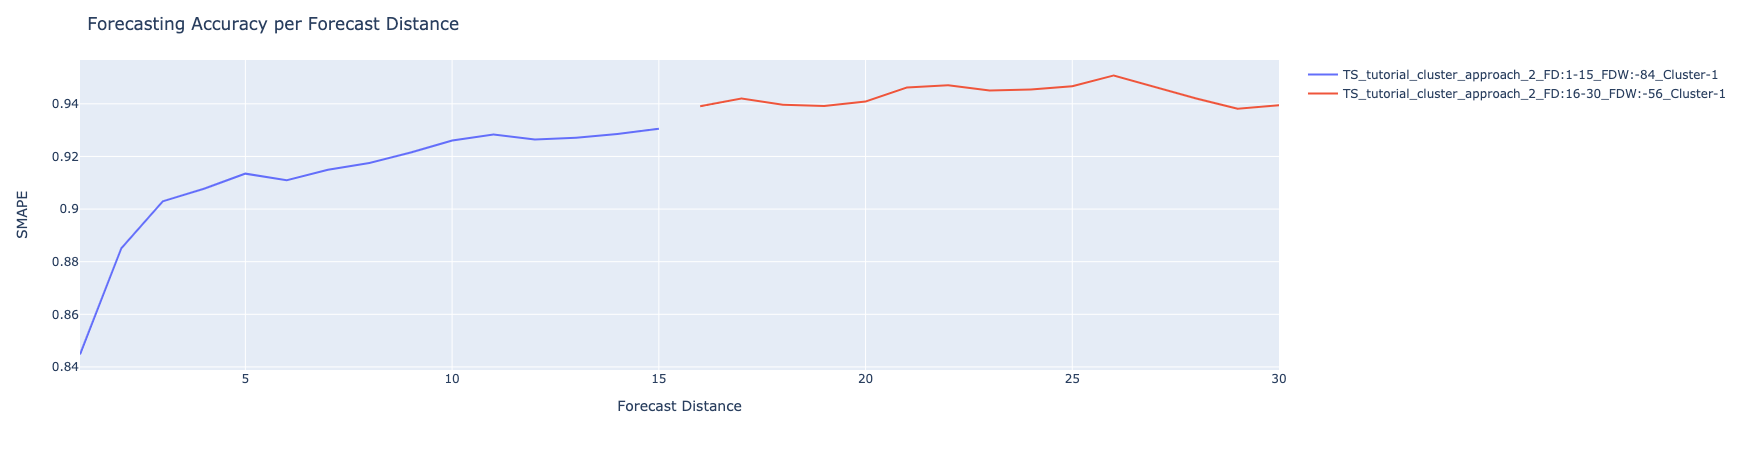

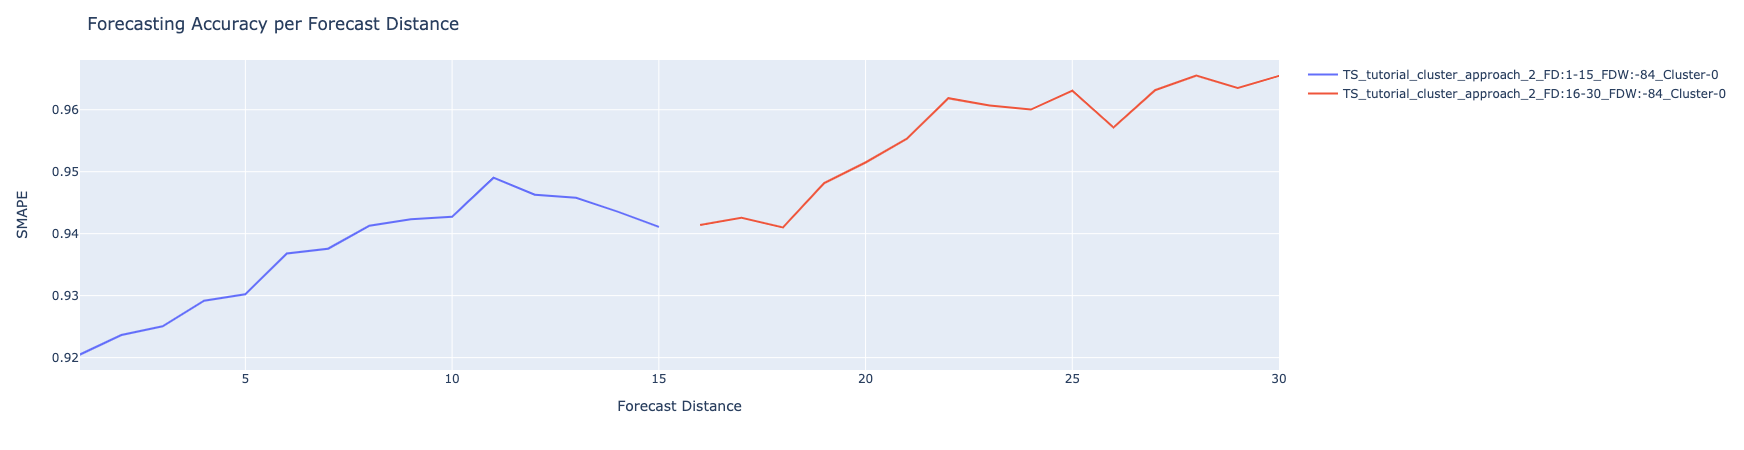

In [102]:
# Project 2
ts.plot_fd_accuracy_by_cluster(
    df_w_clusters_2,
    project2_scores,
    projects2_best,
    ts_settings,
    data_subset="allBacktests",
    metric="SMAPE",
)

## Evaluating performance with RMSE and SMAPE: Projects 3 - Cluster 3 (below)
- Evaluate cluster 3 AOT plots for RMSE and SMAPE
- Notice that Projects 3 - Cluster 3 RMSE performance seems strong, but SMAPE scores are bad
- Why?

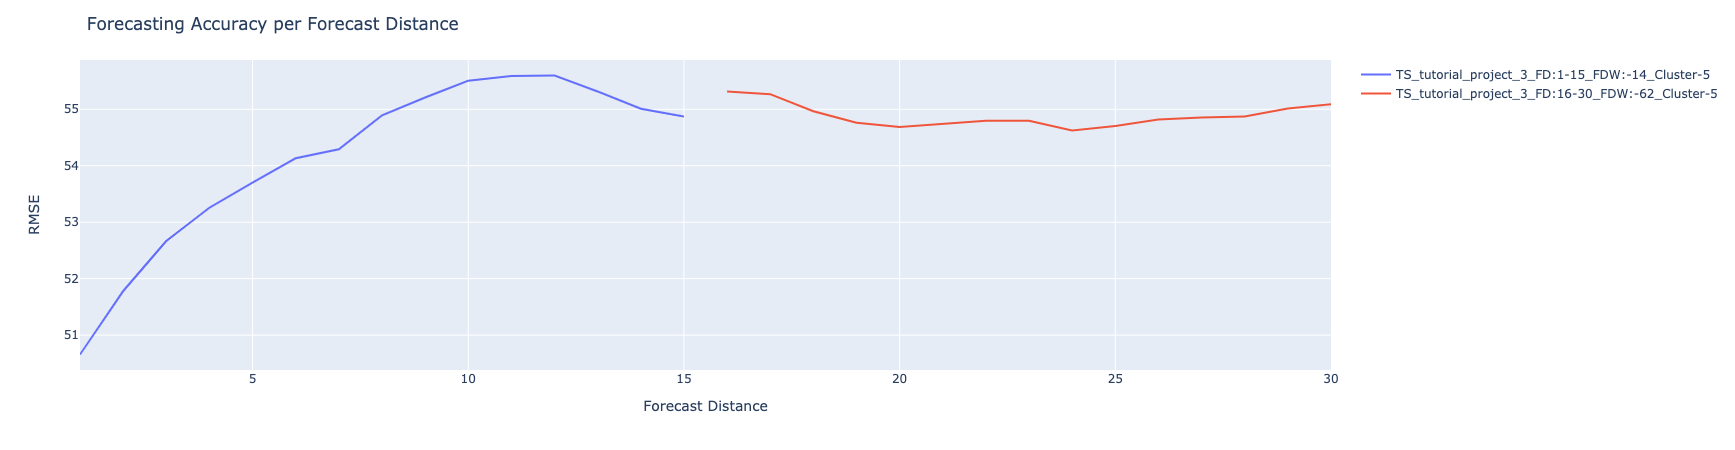

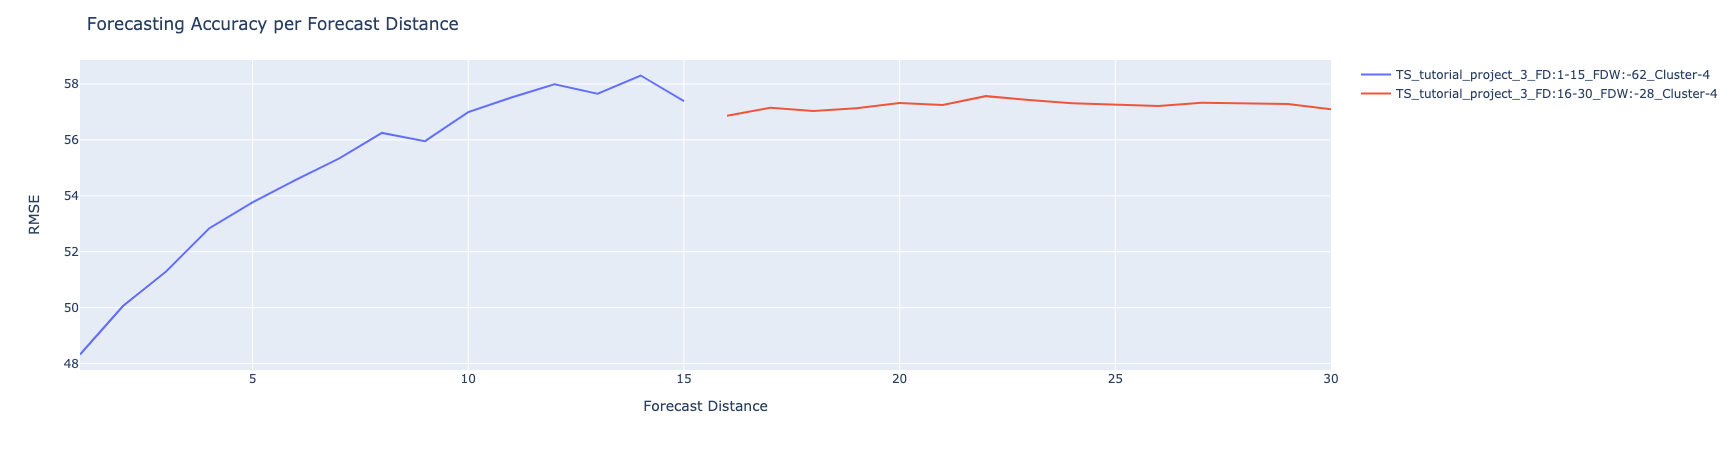

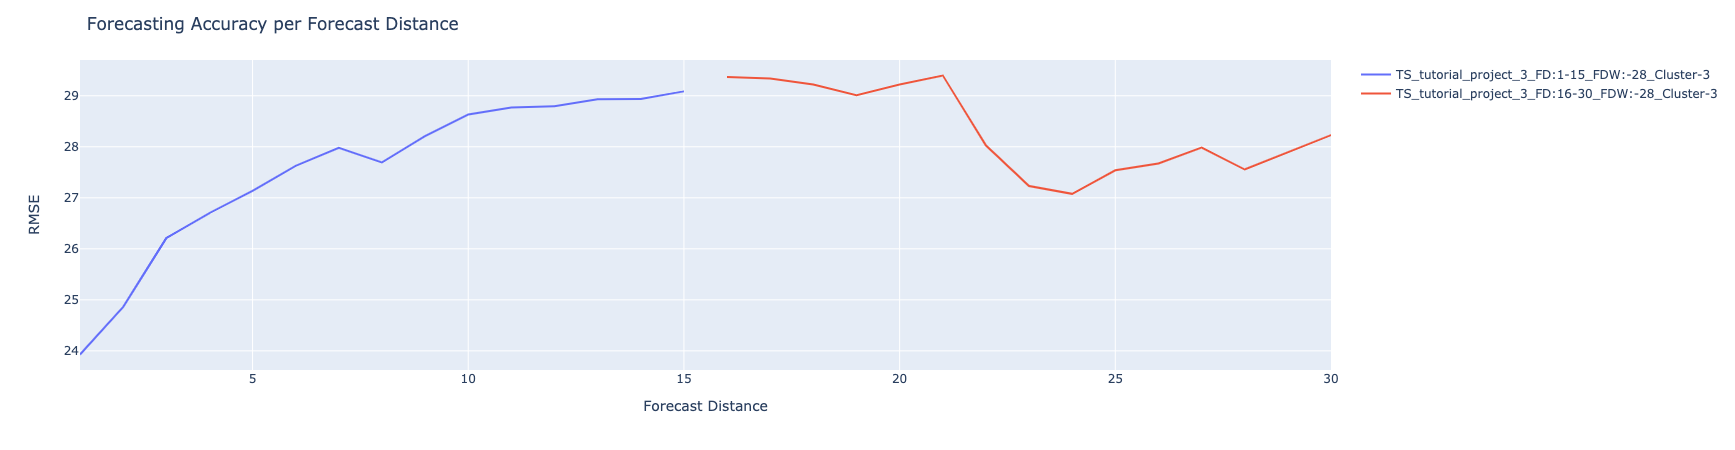

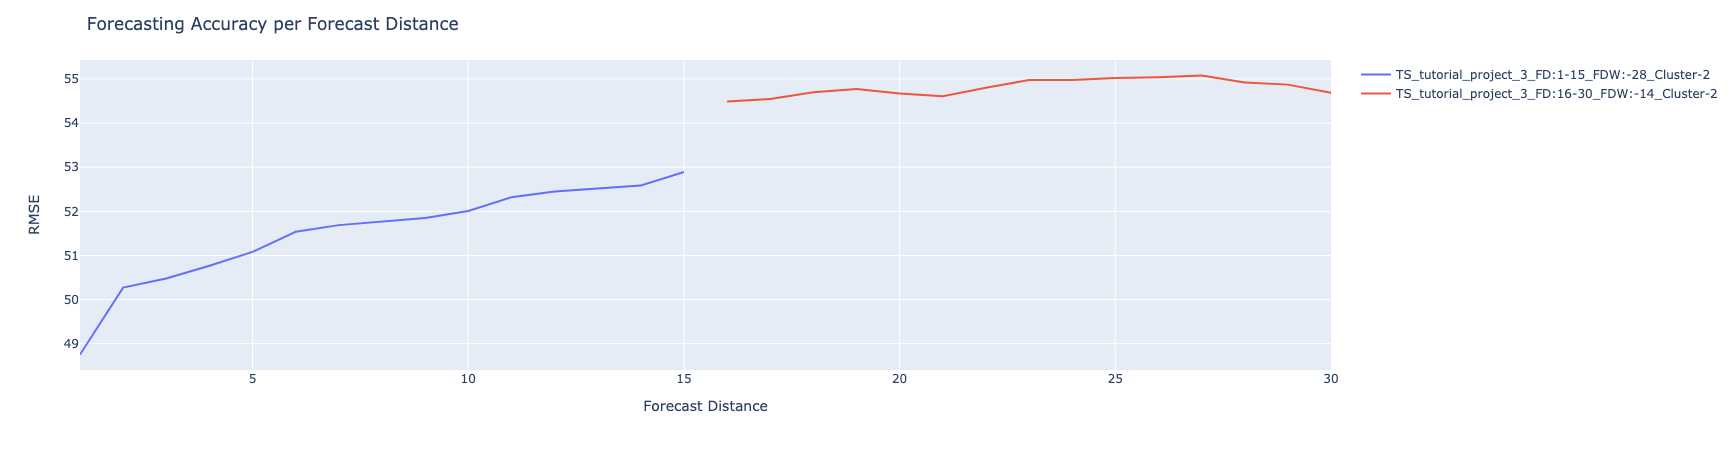

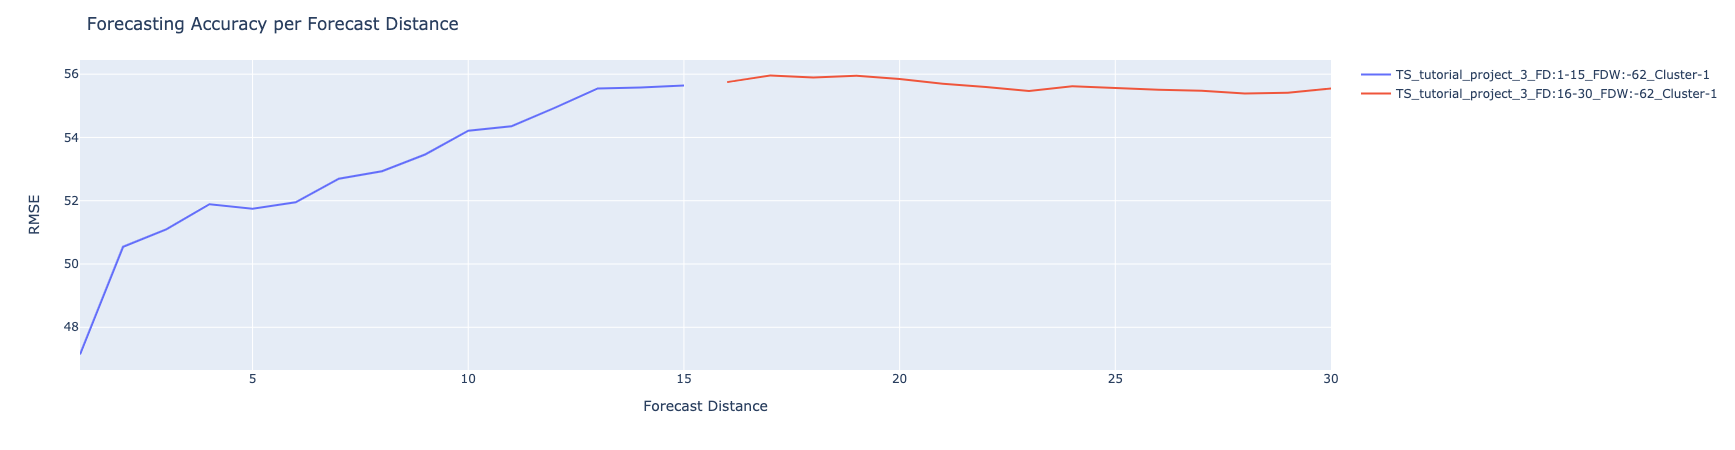

In [296]:
# Project 3
ts.plot_fd_accuracy_by_cluster(
    df_w_clusters_3,
    project3_scores_retrained2,
    projects3_best_retrained2,
    ts_settings,
    data_subset="allBacktests",
    metric="RMSE",
)

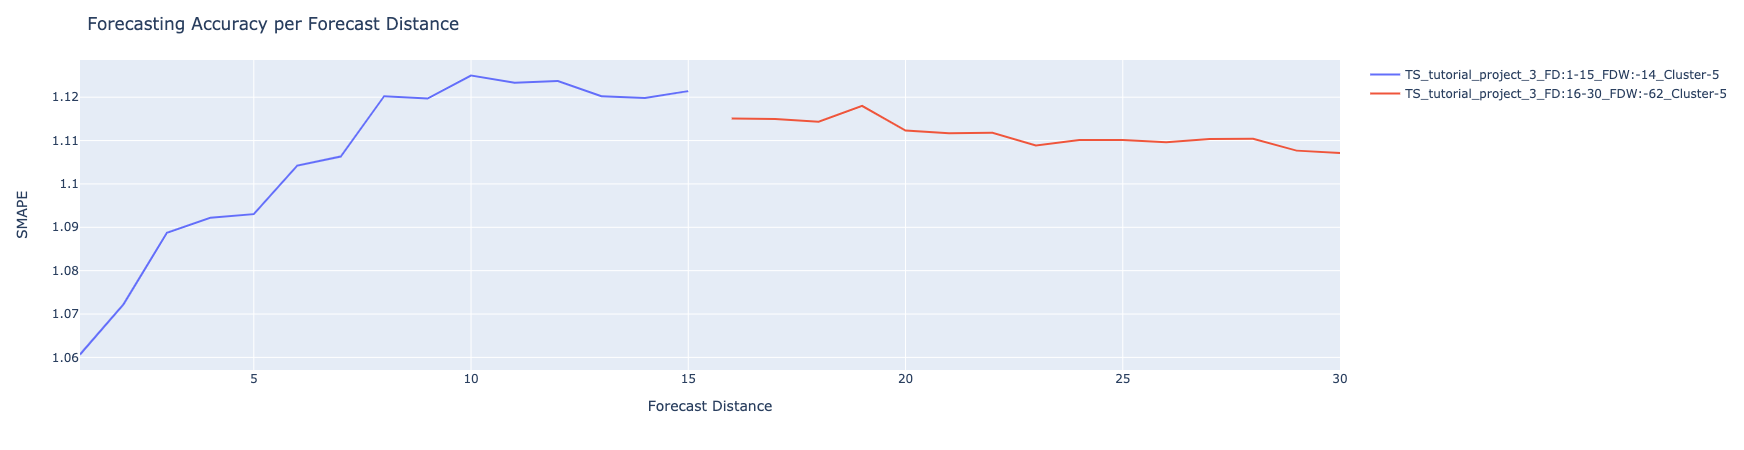

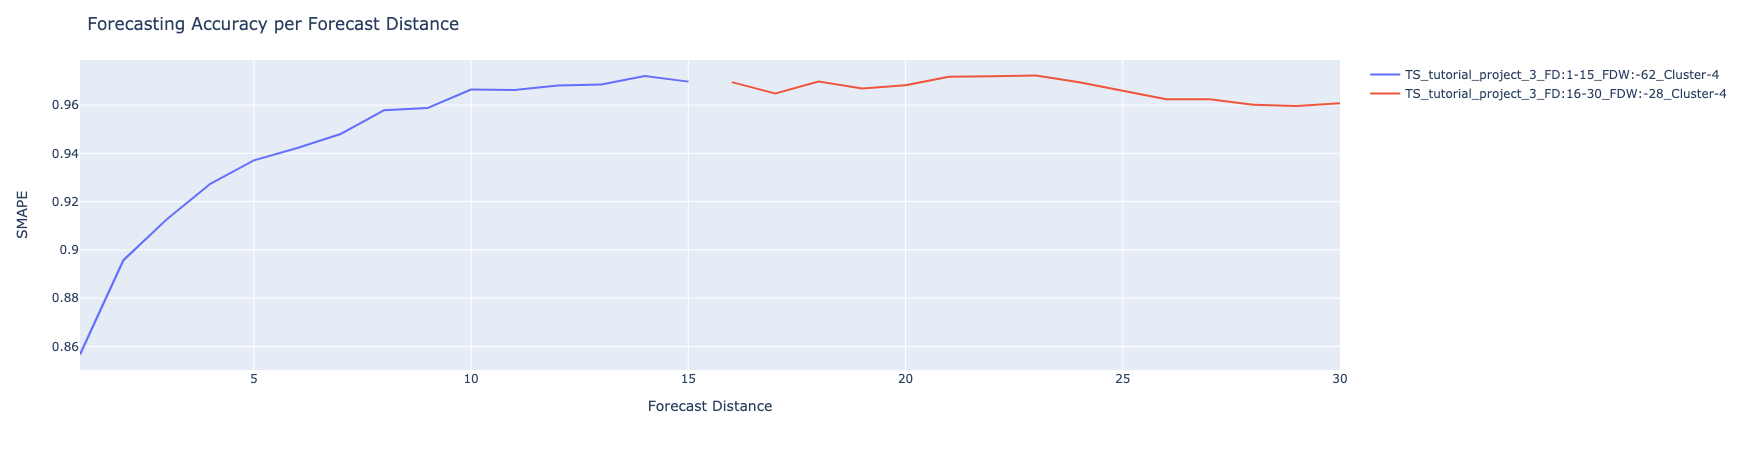

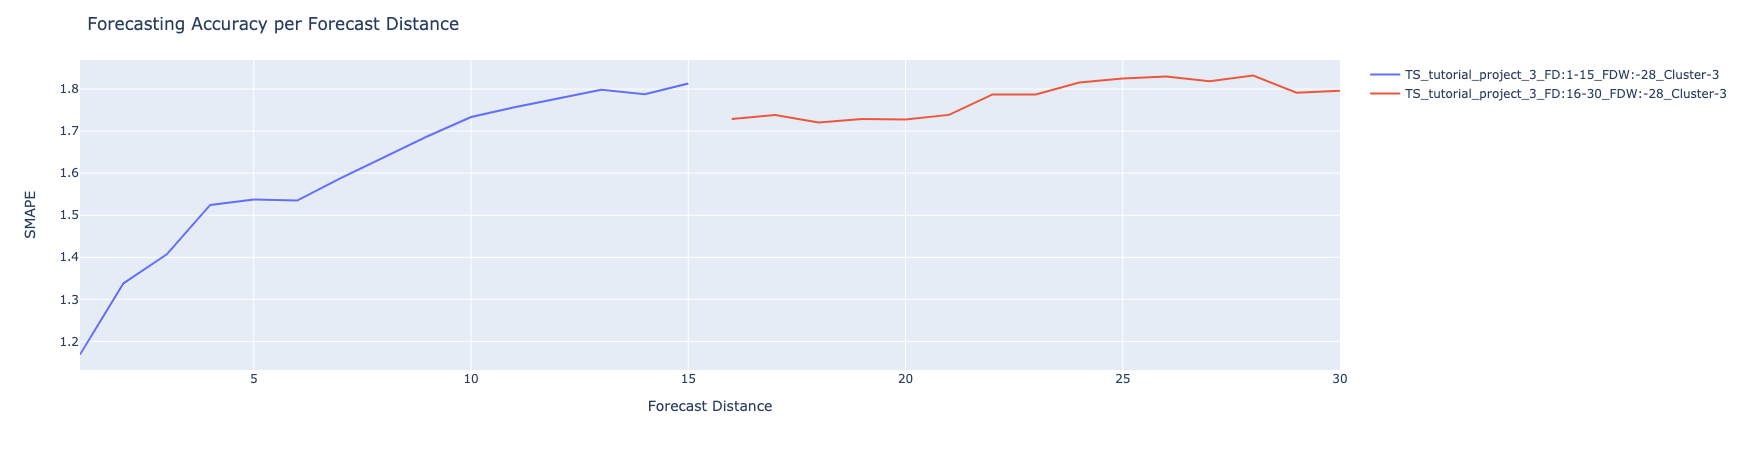

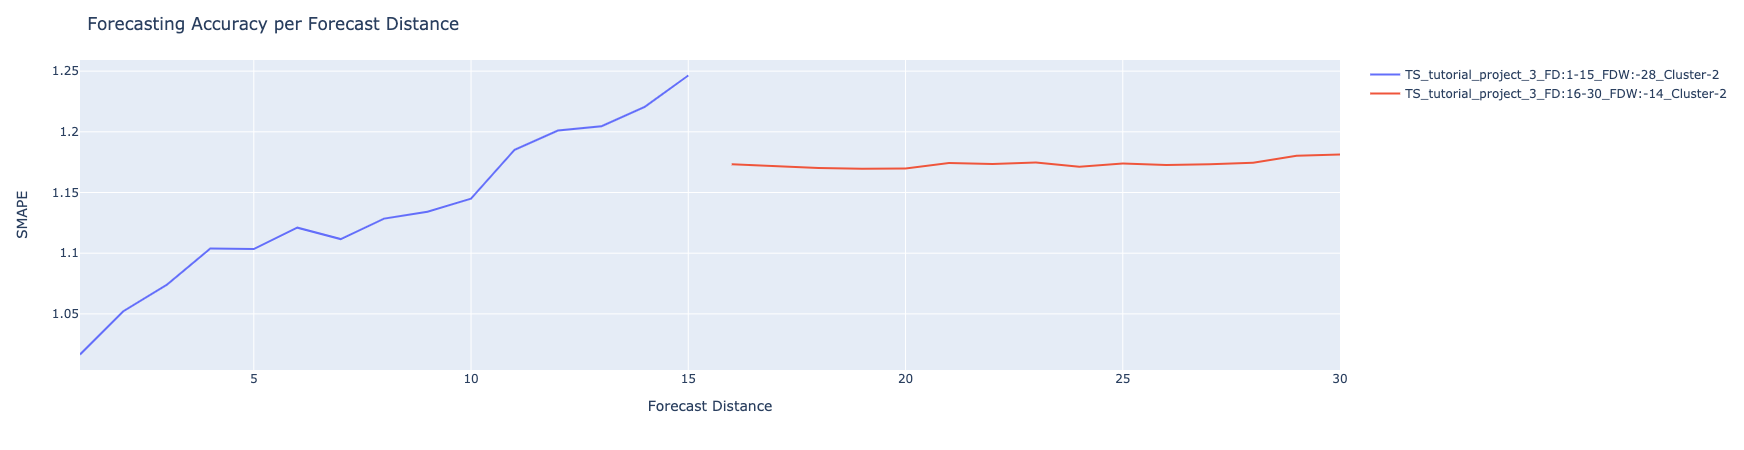

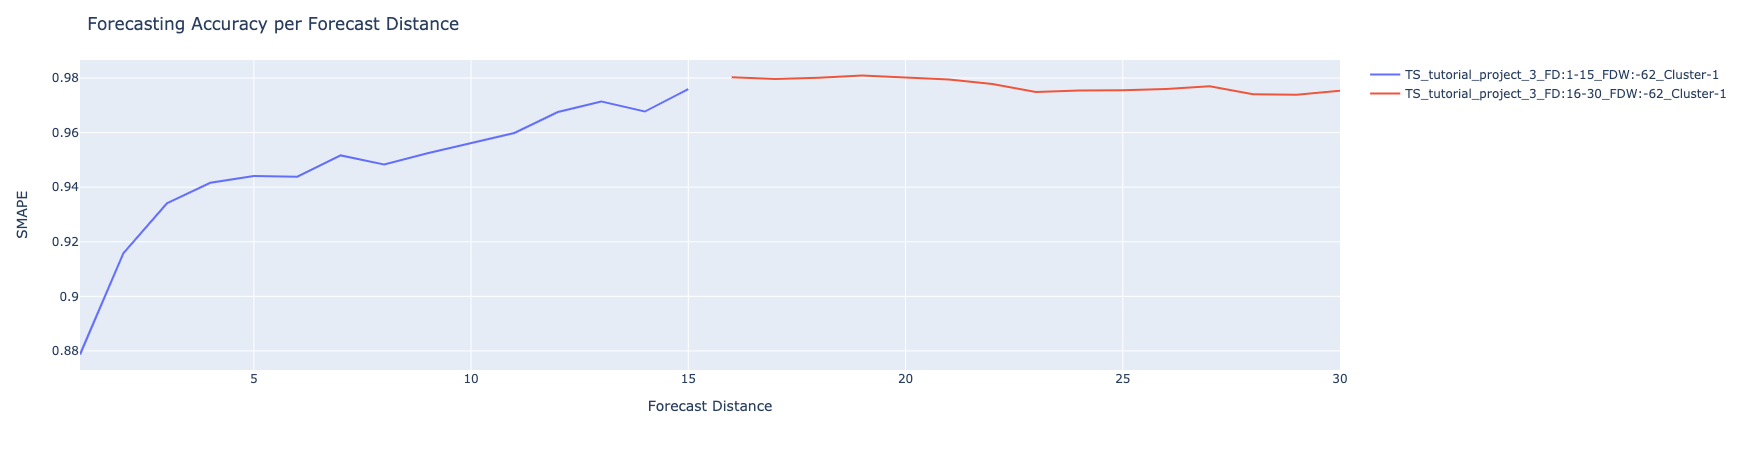

In [297]:
# Project 3
ts.plot_fd_accuracy_by_cluster(
    df_w_clusters_3,
    project3_scores_retrained2,
    projects3_best_retrained2,
    ts_settings,
    data_subset="allBacktests",
    metric="SMAPE",
)

## What about Cluster 3 explains this week performance?

In [135]:
# We can look at all of the series in the training data
cluster_3_series = (
    df_w_clusters_3[df_w_clusters_3["Cluster"] == 3][ts_settings["series_id"]]
    .unique()
    .tolist()
)
cluster_3_series

['Air Heads',
 'Almond Joy',
 'Baby Ruth',
 'Gobstopper',
 'Mike & Ike',
 'Mounds',
 'Nerds',
 'One quarter',
 'Payday',
 'Smarties candy',
 'Sour Patch Tricksters',
 'Swedish Fish',
 'Tootsie Pop',
 'Tootsie Roll Midgies',
 'Trolli Sour Bites']

In [136]:
# but performance results suggest that many fewer series are occur frequently enough to recieve scores
series3_scored_series = series3_acc[series3_acc["Cluster"] == "3"]
series3_scored_series

item_name  Series_RMSE Cluster  Total_RMSE
2              Almond Joy    29.110019       3   46.421591
28            Tootsie Pop     6.335969       3   46.421591
26  Sour Patch Tricksters     4.215286       3   46.421591

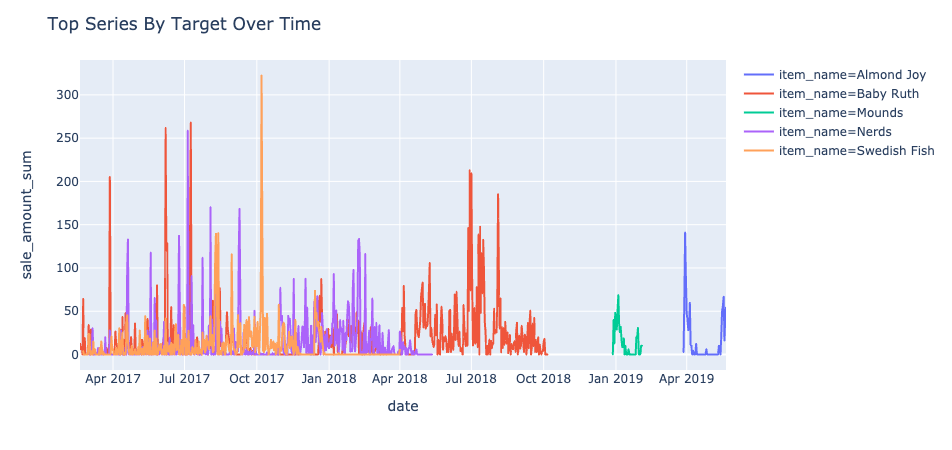

In [140]:
# all series in cluster 3
ts.plot_individual_series(
    df_w_clusters_3[df_w_clusters_3[ts_settings["series_id"]].isin(cluster_3_series)],
    ts_settings,
    n=5,
)

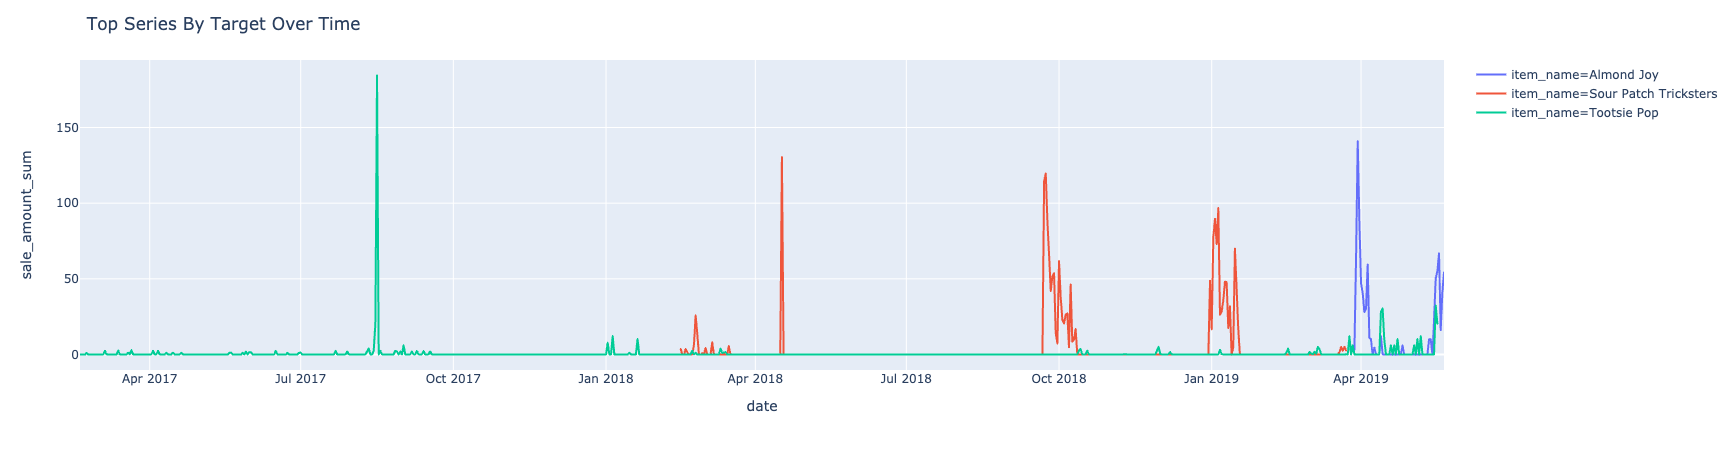

In [139]:
# only the series that get scored
ts.plot_individual_series(
    df_w_clusters_3[
        df_w_clusters_3[ts_settings["series_id"]].isin(
            series3_scored_series[ts_settings["series_id"]].unique().tolist()
        )
    ],
    ts_settings,
    n=5,
)

## We see that cluster contrains series with very sporadic sales, and that these series seem to end before the prediction period (May 2019). Given the highly sporadic and volatile nature of this time series, it will be extremely difficult to model without additional data.

--------------
# Getting predictions from un-deployed models

### You may want to get predictions from un-deployed models, but there are limits of total volume and frequency of scoring for un-deployed models

In [22]:
# Get series and cluster pairs for predictions
series_to_clusters_dict = ts.series_to_clusters(
    df_w_clusters_3, ts_settings, split_col="Cluster"
)

#### 'series_to_clusters_dict()' function docs &darr;

series_to_clusters(df, ts_settings, split_col='Cluster'):
    
    '''
    Creates a series map corresponding to series clusters
    
    df: pandas df
    ts_settings: dict
        Parameters for time series project
    split_col: str
        Column name in df to be used to subset data
    
    Returns:
    --------
    dict
    '''

In [23]:
# Load and prep scoring data
# The last 31 days of data were withheld from the model training process to be used here for predictions
scoring_data = pd.read_csv("data/data_for_predictions.csv", index_col=0)
scoring_data["Cluster"] = scoring_data[series_id].map(series_to_clusters_dict)

In [24]:
scoring_data.head()

item_name        date  package_id_min  package_id_max  \
436           100 Grand  2019-04-21    1.700005e+09    1.700005e+09   
1274       3 Musketeers  2019-04-21    1.700005e+09    1.700005e+09   
1629         Almond Joy  2019-04-21             NaN             NaN   
2605  Haribo Gold Bears  2019-04-21             NaN             NaN   
3813   Hersheys Krackel  2019-04-21    1.700005e+09    1.700005e+09   

      package_id_unique       campaign_min     campaign_max  campaign_unique  \
436                 2.0  discount_type_374  discount_type_1              2.0   
1274                2.0   discount_type_34  discount_type_1              3.0   
1629                NaN                NaN              NaN              NaN   
2605                NaN                NaN              NaN              NaN   
3813                1.0    discount_type_2  discount_type_2              1.0   

      qty_min  qty_mean  qty_max  qty_stdev  qty_unique  qty_sum  \
436      1.96    4.9210     7.88   2.669359        10.0    49.21   
1274     3.93    4.1975     4.96   0.508486         4.0    16.79   
1629      NaN       NaN      NaN        NaN         NaN      NaN   
2605      NaN       NaN      NaN        NaN         NaN      NaN   
3813    46.94   46.9400    46.94        NaN         1.0    46.94   

      unit_price_min  unit_price_mean  unit_price_max  unit_price_stdev  \
436             1.12            2.106            2.99          0.591649   
1274            0.73            1.570            2.67          0.978809   
1629             NaN              NaN             NaN               NaN   
2605             NaN              NaN             NaN               NaN   
3813            1.53            1.530            1.53               NaN   

      unit_price_unique  unit_price_sum  sale_amount_min  sale_amount_mean  \
436                10.0           21.06             3.58           10.0250   
1274                4.0            6.28             3.01            6.3675   
1629                NaN             NaN              NaN               NaN   
2605                NaN             NaN              NaN               NaN   
3813                1.0            1.53            71.82           71.8200   

      sale_amount_max  sale_amount_stdev  sale_amount_unique  sale_amount_sum  \
436             19.18           5.731853                10.0           100.25   
1274            10.49           3.639912                 4.0            25.47   
1629              NaN                NaN                 NaN             0.00   
2605              NaN                NaN                 NaN             0.00   
3813            71.82                NaN                 1.0            71.82   

      day store_category category transaction  aggregated_total_count  \
436   Sun         Type_B   Retail        Good                    10.0   
1274  Sun         Type_B   Retail        Good                     4.0   
1629  NaN            NaN      NaN         NaN                     NaN   
2605  NaN            NaN      NaN         NaN                     NaN   
3813  Sun         Type_B   Retail        Good                     1.0   

      metro_area  county_1  total_market_sales Cluster  
436          NaN       NaN                 NaN       1  
1274         NaN       NaN                 NaN       2  
1629         NaN       NaN                 NaN       2  
2605         NaN       NaN                 NaN       2  
3813         NaN       NaN                 NaN       2

In [26]:
# add cross-series features and correct column type
scoring_data = ts.create_cross_series_features(
    scoring_data,
    group=[date_col, "Cluster"],
    cols=[target],
    funcs=["mean", "std", "min", "max"],
)
scoring_data[date_col] = pd.to_datetime(scoring_data[date_col])

# create a dictionary to add cluster labels for series
# if we have new series at this point, we would need to choose a cluster to manually assign the series into
clusters_to_series_dict = clusters_to_series(df_w_clusters_3, ts_settings)

In [27]:
%%time
stats = ts.get_project_stats(
    projects3_best,
    n_models=1,
    cluster_to_series_map=clusters_to_series_dict,
    split_col="Cluster",
    prefix="TS_tutorial_project_3",
    metric="RMSE",
    data_subset="holdout",
)
stats

CPU times: user 1.89 s, sys: 21.4 ms, total: 1.91 s
Wall time: 1min 37s


Project_Name                Project_ID  \
0  TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5  5ed8f4dfaa1039183cff70ff   
1   TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5  5ed8c296aa10391697ff6f92   
2   TS_tutorial_project_3_FD:1-15_FDW:-62_Cluster-4  5ed8bed518bd1d17263144e8   
3  TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-4  5ed8bd82aa10391697ff6e9c   
4  TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-3  5ed8b50118bd1d16653149fe   
5   TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-3  5ed8b36b18bd1d1665314940   
6   TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-2  5ed8695118bd1d1359314c2b   
7  TS_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2  5ed8679d18bd1d1372314bf4   
8  TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-1  5ed862b1aa103913e2ff6f0f   
9   TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1  5ed849c5aa103912c1ff6f06   

  Cluster     FD  FDW                                         Model_Type  \
0       5  16-30  -62  Temporal Hierarchical Model with Elastic Net a...   
1       5   1-15  -14  Zero-Inflated eXtreme Gradient Boosted Trees R...   
2       4   1-15  -62                  Vector Autoregressive Model (VAR)   
3       4  16-30  -28                  Vector Autoregressive Model (VAR)   
4       3  16-30  -28  Per Series Elastic Net Regressor with Forecast...   
5       3   1-15  -28  Performance Clustered eXtreme Gradient Boostin...   
6       2   1-15  -28    Ridge Regressor with Forecast Distance Modeling   
7       2  16-30  -14  Similarity Clustered eXtreme Gradient Boosted ...   
8       1  16-30  -62  Elastic-Net Regressor (mixing alpha=0.5 / Leas...   
9       1   1-15  -14  eXtreme Gradient Boosting on ElasticNet Predic...   

                   Model_ID                                             Series  
0  5ede583d837c2a3deed24fb9      [Reeses Miniatures, Reeses Peanut Butter cup]  
1  5ede58827928563d8944b981      [Reeses Miniatures, Reeses Peanut Butter cup]  
2  5ede58e47928563dba44ba95  [Hersheys Milk Chocolate, Kit Kat, Nestle Butt...  
3  5ed8becddc15425168780082  [Hersheys Milk Chocolate, Kit Kat, Nestle Butt...  
4  5ede596f837c2a3e00d2500b  [Air Heads, Baby Ruth, Gobstopper, Mike & Ike,...  
5  5ede59bc7928563ddb44b906  [Air Heads, Baby Ruth, Gobstopper, Mike & Ike,...  
6  5ed9769dae4c4f41e81f109e  [3 Musketeers, Almond Joy, Haribo Gold Bears, ...  
7  5ee007340b59f90c10b9eeee  [3 Musketeers, Almond Joy, Haribo Gold Bears, ...  
8  5ede5ad5837c2a3e00d251dc  [100 Grand, M&Ms, Milk Duds, Milky Way, Mr Goo...  
9  5ed85a67d440a22401b48c81  [100 Grand, M&Ms, Milk Duds, Milky Way, Mr Goo...

#### 'get_project_stats()' function docs &darr;

get_project_stats(
    projects, n_models, cluster_to_series_map, metric=None, split_col='Cluster', prefix='TS', data_subset= 'allBacktests'
):
    
    '''
    projects: list
        list of DataRobot model objects
    n_models: int
        number of models to select from each DR project
    cluster_to_series_map: dict
        Dictionary to remap series and clusters
    metric: str
        Metric to be used for sorting the leaderboard, if None uses project metric
    split_col: str
        Column name in df to be used to subset data
    prefix: str
        Label to append to project name
     data_subset: str (optional)
        Can be set to either allBacktests or holdout
    
    Returns:
    --------
    Pandas df
    '''

In [88]:
%%time
# get the top models from all projects
models_best = ts.get_top_models_from_projects(
    projects3_best,
    n_models=1,
    data_subset="holdout",
    include_blenders=True,
    metric="RMSE",
)

# configure the forecast point
end = df_w_clusters_3["date"].max()
forecast_point = pd.to_datetime(end) + pd.DateOffset(1)

CPU times: user 1.95 s, sys: 28.6 ms, total: 1.98 s
Wall time: 1min 39s


#### 'get_or_request_predictions()' function docs &darr;

get_or_request_predictions(
    models,
    scoring_df,
    training_df,
    ts_settings,
    deployments= None,
    project_stats=None,
    start_date=None,
    end_date=None,
    forecast_point=None,
    retrain=False,
):

    '''
    models: list
        list of DataRobot datetime project objects
    deployments: list
        list of DataRobot deployment ids
    scoring_df: pandas df
        Predictions dataframe that contains required information (KIA, future datetime stamp, etc) correspond to a desired range of predictions
    training_df: pandas df (optional)
        Predictions dataframe that contains training data used to build the model, required to augment FDW data
    ts_settings: dict
        Parameters for the time series projects in DR
    project_sats: pandas df
        output of get_project_stats(), contains detailed information on DR projects
    start_date: datetime
        Desired start date for DR project retraining from a frozen model
    end_date: datetime
        Desired end date for DR project retraining from a frozen model
    forecast_point: datetime
        Desired forecast point for start of predictions, must be configured associated with scoring_df
    retrain: bool
        Controls if a frozen DR datetime model will be retrained on a new training period
        
    Returns:
    --------
    pandas df
    '''

In [107]:
%%time
# get predictions from undeployed models
preds = ts.get_or_request_predictions(
    models=models_best,
    project_stats=stats,
    scoring_df=scoring_data,
    training_df=df_w_clusters_3,
    ts_settings=ts_settings,
    start_date=None,
    end_date=None,
    forecast_point=forecast_point,
)


DatetimeModel('Temporal Hierarchical Model with Elastic Net and XGBoost')
Training Data Start Date:  2017-05-06
Training Data End Date:  2019-04-20
FDW start for predictions:  2019-02-18
Forecast point:  2019-04-21
*** Values required to generate FDW for predictions are present in training_df and will be appended to scoring_df ***
Uploading scoring dataset for Project TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5

DatetimeModel('Zero-Inflated eXtreme Gradient Boosted Trees Regressor with Early Stopping (Poisson Loss)')
Training Data Start Date:  2017-03-04
Training Data End Date:  2019-04-20
FDW start for predictions:  2019-04-07
Forecast point:  2019-04-21
*** Values required to generate FDW for predictions are present in training_df and will be appended to scoring_df ***
Uploading scoring dataset for Project TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5

DatetimeModel('Vector Autoregressive Model (VAR)')
Training Data Start Date:  2017-04-21
Training Data End Date:  2019-04-20


In [171]:
%%time
preds_and_actuals = ts.merge_preds_and_actuals(preds, scoring_data, ts_settings)
undeployed_error = ts.rmse(
    preds_and_actuals["prediction"], preds_and_actuals[ts_settings["target"]]
)
print("RMSE: ", undeployed_error)

RMSE:  49.4680487467882
CPU times: user 9.27 ms, sys: 1.26 ms, total: 10.5 ms
Wall time: 9.34 ms


-----------------
# Model deployment

### Instead of getting predictions on undeployed models, we can quickly deploy those models and get predicitons

#### 'deploy_models()' function docs &darr;

deploy_models(models, labels= None, descriptions= None, pred_server= None):
    
    """
    Deploy a list of DataRobot models
    
    models: list
        list of DataRobot model objects to deploy
    labels: list (optional)
        list of str for title of deployments
    descriptions: list (optional)
        list of str for description for deployments
    pred_server: datarobot.models.prediction_server.PredictionServer (optional)
        DataRobot prediction server object, or None and will automatically retrieve the first option
        
    Returns:
    --------
    deployments: list
    """

In [162]:
# def deploy_models(models, labels= None, descriptions= None, pred_server= None):
#     """
#     Deploy a list of DataRobot models

#     models: list
#         list of DataRobot model objects to deploy
#     labels: list (optional)
#         list of str for title of deployments
#     descriptions: list (optional)
#         list of str for description for deployments
#     pred_server: datarobot.models.prediction_server.PredictionServer (optional)
#         DataRobot prediction server object, or None and will automatically retrieve the first option

#     Returns:
#     --------
#     deployments: list
#     """

#     assert isinstance(models, list), 'models must be a list of DataRobot models'
#     if labels is not None:
#         assert isinstance(labels, list), 'labels must be a list of desired Deployment titles or None'
#         assert len(models) == len(labels), 'labels must contain the same number of entries as models to be deployed'
#     if descriptions is not None:
#         assert isinstance(descriptions, list), 'descriptions must be a list of desired Deployment descriptions or None'
#         assert len(models) == len(descriptions), 'descriptions must contain the same number of entries as models to be deployed'
#     if pred_server is not None:
#         assert isinstance(pred_server, datarobot.models.prediction_server.PredictionServer), 'pred_server must be a datarobot.models.prediction_server.PredictionServer object or None'

#     deployments = []

#     # get values if not supplied
#     if labels is None:
#         labels = [dr.Project.get(x.project_id).project_name for x in models]
#     if descriptions is None:
#         descriptions = [f'Deployment of best model from {dr.Project.get(x.project_id).project_name}' for x in models]
#     if pred_server is None:
#         pred_server = dr.PredictionServer.list()[0]

#     # create deployment for each model
#     for m, l, d in list(zip(models, labels, descriptions)):
#         try:
#             deployments.append(dr.Deployment.create_from_learning_model(m.id, label= l, description= d, default_prediction_server_id = pred_server.id))
#             print(f'Deployment of {m.model_type} into {dr.Project.get(m.project_id).project_name} successful!')
#         except:
#             print(f'*** Something went wrong when deploying {m.model_type} ***')

#     # return list of deployment objects
#     return deployments

In [163]:
# deploy desired models using default settings
test_deployments = ts.deploy_models(models_best)

Deployment of Temporal Hierarchical Model with Elastic Net and XGBoost into TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5 successful!
Deployment of Zero-Inflated eXtreme Gradient Boosted Trees Regressor with Early Stopping (Poisson Loss) into TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 successful!
Deployment of Vector Autoregressive Model (VAR) into TS_tutorial_project_3_FD:1-15_FDW:-62_Cluster-4 successful!
Deployment of Vector Autoregressive Model (VAR) into TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-4 successful!
Deployment of Per Series Elastic Net Regressor with Forecast Distance Modeling into TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-3 successful!
Deployment of Performance Clustered eXtreme Gradient Boosting on Elastic Net Predictions into TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-3 successful!
Deployment of Ridge Regressor with Forecast Distance Modeling into TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-2 successful!
Deployment of Similarity Clustered eXtrem

In [164]:
# check the list of deployments just created
test_deployments

[Deployment(TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5),
 Deployment(TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5),
 Deployment(TS_tutorial_project_3_FD:1-15_FDW:-62_Cluster-4),
 Deployment(TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-4),
 Deployment(TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-3),
 Deployment(TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-3),
 Deployment(TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-2),
 Deployment(TS_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2),
 Deployment(TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-1),
 Deployment(TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1)]

In [165]:
%%time
# get predictions from deployed models
test = ts.get_or_request_predictions(
    models=None,  # for a deployment, no models need to be specified
    project_stats=stats,
    scoring_df=scoring_data,
    training_df=df_w_clusters_3,
    ts_settings=ts_settings,
    deployments=test_deployments,  # instead specify a list of deployment objects
    start_date=None,
    end_date=None,
    forecast_point=forecast_point,
)

Accessing model from TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5 deployment
Accessing model from TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 deployment
Accessing model from TS_tutorial_project_3_FD:1-15_FDW:-62_Cluster-4 deployment
Accessing model from TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-4 deployment
Accessing model from TS_tutorial_project_3_FD:16-30_FDW:-28_Cluster-3 deployment
Accessing model from TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-3 deployment
Accessing model from TS_tutorial_project_3_FD:1-15_FDW:-28_Cluster-2 deployment
Accessing model from TS_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2 deployment
Accessing model from TS_tutorial_project_3_FD:16-30_FDW:-62_Cluster-1 deployment
Accessing model from TS_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1 deployment

Model('Temporal Hierarchical Model with Elastic Net and XGBoost')
Training Data Start Date:  2017-05-06
Training Data End Date:  2019-04-20
FDW start for predictions:  2019-02-18
Forecast point:

In [173]:
%%time
deployed_preds_and_actuals = ts.merge_preds_and_actuals(test, scoring_data, ts_settings)
deployed_error = ts.rmse(
    deployed_preds_and_actuals["prediction"],
    deployed_preds_and_actuals[ts_settings["target"]],
)
print("Deployed RMSE: ", deployed_error)
print("Un-deployed RMSEL ", undeployed_error)

Deployed RMSE:  49.4680487467882
Un-deployed RMSEL  49.4680487467882
CPU times: user 8.88 ms, sys: 1.45 ms, total: 10.3 ms
Wall time: 8.99 ms


-------------
# Thats all for now.

### Please reach out to justin.swansburg@datarobot.com, jarred.bultema@datarobot.com, or jess.lin@datarobot.com with any questions, comments, or bugs